# Fraud detection

Dataset: https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud

# Introduction

Ce notebook est organisé comme suit
- Châpitre 3 : analyse exploratoire et principales caractéristiques du jeu de données
- Châpitre 4 : recherche de corrélations
- Châpitre 5 : précautions méthodologiques dans l'élaboration des modèles et qualité des prédictions
- Châpitre 6 : modèles prédictifs "SGDCLassfier" avec transformation "standard" des données
- Châpitre 7 : modèle "Linear SVC" avec transformation "standard" des données 
- Châpitre 8 : modèle prédictif "SGDClassifier" avec 'approximate kernel map'
- Châpitre 9 : modèle prédictif "Decisition Tree"
- Châpitre 10: modéle prédictif ensembliste "histgradienboosting"
- Châpitre 11: modéle prédictif ensembliste "Random Forest"
- Châpitre 12: modème prédictif avec 'undersampling' and 'oversampling'
- Châpitre 13: synthèse et conclusion
- Annexe 1 : exploiration des données par ACP (Analyse en Composante Principale)
- Annexe 2 : choix de la méthode scoring
- Annexe 3 : distribution des features de distance et ratio
- Annexe 4 : détail du modèle prédictif Linear SVC

Appel des différentes bibliothèques utilisées

In [9]:
import pandas as pd
import numpy as np
from numpy import random
from scipy import stats
from scipy.stats import randint

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    
import seaborn as sns


from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder # vérifier si utile

preprocessor_StdScaler = StandardScaler()
preprocessor_RobScaler = RobustScaler()
preprocessor_MMScaler = MinMaxScaler()

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score #Evaluate a score by cross-validation.

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,roc_auc_score,recall_score,precision_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [2]:
#pour afficher les pipelines et estimators
from sklearn import set_config

# To get a diagram visualization of the classifier, pipeline
set_config(display="diagram")

In [17]:
#création d'un dataframe plus facile pour l'analyse, transformation et visualisation (que d'un np.array)

df=pd.read_csv("/Users/slimkachkachi/Documents/IA_Dauphine/Machine Learning/Projet_ML(Kaggle)/Dataset/card_transdata.csv")
#df = pd.read_csv("card_transdata.csv")

# Exploratory analysis

**Le jeu de données comprend 7 features et 1 target (fraud) avec 1 million d'enregistrements (1)**

Il s'agit d'un problème de **classification binaire** où la 'target' peut prendre deux valeurs (O et 1 a priori pour un cas de fraude).

Toutes les données sont typées numériques (float) même si certaines s'apparentent à des booléans.
A noter que :
- **deux features concernent des distances (avec de grandes amplitudes de valeurs)**
- **une feature est adimentionnelle** (ratio entre prix /prix achat)
- des informations sur les conditions d'achat (utilisation de carte bancaire, saisie d'un code pin, achat en ligne)

**(1) La taille du jeu de données sera à prendre en compte dans le choix de certains estimateurs.** Par exemple pour le classifier "SVC" : 'the fit time scales at least quadratically with the number of samples' ou encore certains kernel trick ne passe pas bien à l'échelle.

## Database structure

In [6]:
#nombre de features et d'enregistrements
print(
    f"The dataset contains {df.shape[0]} samples and "
    f"{df.shape[1]-1} columns"
)

The dataset contains 1000000 samples and 7 columns


In [7]:
# affichage du nom des colonnes
df.head(1)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.31114,1.94594,1.0,1.0,0.0,0.0,0.0


In [8]:
#affichage des types par colonne
df.dtypes

distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                   float64
used_chip                         float64
used_pin_number                   float64
online_order                      float64
fraud                             float64
dtype: object

##  Data Cleaning (Recherche d'anomalies dans le jeu de données)

**L'analyse montre qu'il n'y a pas de données manquantes, pas de doublon.**

In [9]:
# vérification de l'absence de données manquantes
df.isnull().sum().sort_values(ascending=False)

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [10]:
# vérification de l'absence de doublons
np.bincount(df.duplicated())

array([1000000], dtype=int64)

In [18]:
#nommage et regroupement des features pour faciliter les manipulations dans la suite du notebook
target_column="fraud"
target_values=[0.0,1.0]

numerical_columns = [
    "distance_from_home",
    "distance_from_last_transaction",
    "ratio_to_median_purchase_price"    
]

boolean_columns = [
    "repeat_retailer",
    "used_chip",
    "used_pin_number",
    "online_order"
]
all_features=numerical_columns+boolean_columns
all_columns=numerical_columns+boolean_columns+[target_column]

X=df[all_features]
y=df[target_column]

## Caractéristiques du jeu de données et enseignements

### Focus sur la target 

**La target présente un fort déséquilibre de % entre ses deux modalités.**

En revanche, **la valeur à "1"  (correspondant à la fraude) semblent distribuées de façon uniforme sur le jeu de données** (pas de concentration des 0 pas exemple dans une partie du jeux de données).

Déséquilibre et distribution, **deux caractéristiques à considérer dans le choix du scoring pour la première  et la méthode de split pour la seconde (cf. chapitre sur la méthodologie).**

In [5]:
#Fréquence des différentes valeurs de la target -> très déséquilibrée
#Impose des précautions dans le choix de la méthode #scoring='balanced_accuracy ou recall & precision

unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts/len(y))).T)

[[0.       0.912597]
 [1.       0.087403]]


9353


([<matplotlib.axis.YTick at 0x15cb87059a0>,
 [Text(0, 0, ''), Text(0, 0, '')])

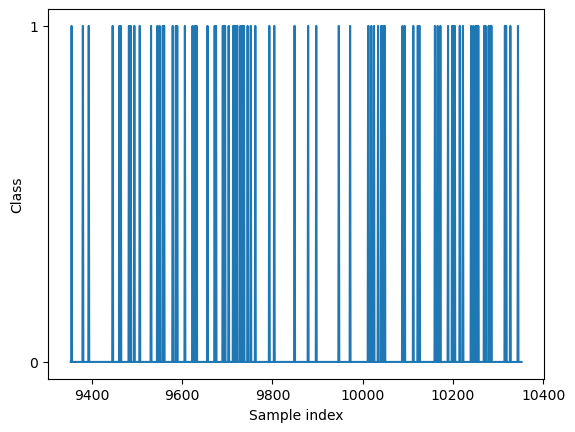

In [13]:
#Distribution des valeurs a priori uniforme (pas de regroupement des valeurs qui pourrait fausser l'uniformité des splits) 
# plage valeur d'observation aléatoire

x = random.randint(10000)
print(x)
y[x:x+1000].plot()
plt.xlabel("Sample index")
plt.ylabel("Class")
plt.yticks(y.unique())

In [14]:
#A noter paas de cas de fraude sur les grandes de valeurs de distance et ratio

boolean_mask = (df['distance_from_last_transaction']>2000) | (df['distance_from_home']>2000) | (df['ratio_to_median_purchase_price']>100)

df_bis= df[boolean_mask].reset_index(drop=True)

unique, counts = np.unique(df_bis['fraud'], return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 0. 53.]
 [ 1. 41.]]


### Focus sur les features et recherche d'outliers

**Les features sont très différentes en nature (distance, adimentionnelle, 'booléenne') et présentent des distributions de modalités très déséquilibrées.**

Il faudra **en tenir compte dans la préparation des données avec l'utilisation probable de transformers (cf. châpitre méthodologie) selon le choix du classifier.**

Sinon la distribution des features de distance et de ratio  présente une forte asymétrie à droite ('skewness' => long tail à droite), en particulier pour la variable distance avec l'ancien lieu de transaction et un 'kurtosis' élevé (coef d'aplatissement faible).

**En transformant ces trois features ont peut constater qu'elles ont une distribution log normale.**

In [15]:
#vision synthétique du profil de distribution des valeurs (min, max, mean, kurtosis,skewness )
stats.describe(df[numerical_columns])

DescribeResult(nobs=1000000, minmax=(array([0.00487439, 0.00011828, 0.00439924]), array([10632.72367224, 11851.10456495,   267.80294218])), mean=array([26.62879219,  5.0365194 ,  1.82418198]), variance=array([4275.95468432,  667.86546931,    7.83769801]), skewness=array([ 20.23970274, 125.92103697,   8.91500173]), kurtosis=array([ 1471.60828985, 46979.03682617,   289.50185347]))

Distribution des valeurs pour features de distance et ratio

Text(0.5, 1.0, 'distribution distance_from_home')

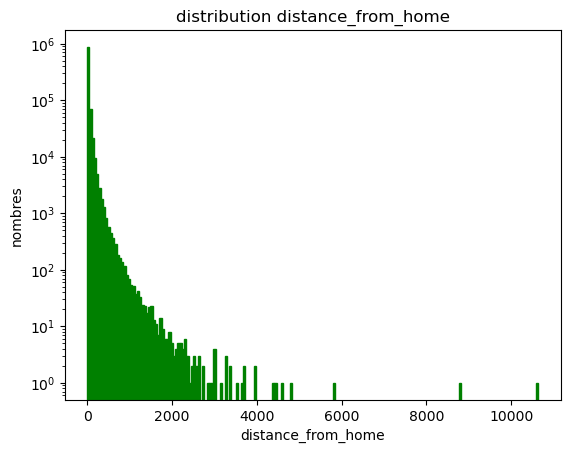

In [17]:
#distribution des valeurs distance_from_home' quelques points très éloignés 
x_index = 'distance_from_home'
x=df[x_index]

plt.hist(x, range=(x.min(), x.max()), bins = 200, color = 'green',
            edgecolor = 'green',log=True)
plt.xlabel('distance_from_home')
plt.ylabel('nombres')
plt.title('distribution distance_from_home')

In [18]:
#Pas de correspondance directe entre ces valeurs extrèmes et les cas de fraudres
boolean_mask = df['distance_from_home']> 6000
#dataset[boolean_mask]['distance_from_home'].value_counts()
df[boolean_mask].head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
326661,10632.723672,1.151871,3.310613,1.0,0.0,0.0,1.0,1.0
847723,8777.136420,0.207396,3.441051,1.0,0.0,0.0,0.0,0.0


Les distributions des features 'distance_from_last_transaction' et 'distance_from_last_transaction' sont présentées en annexe.

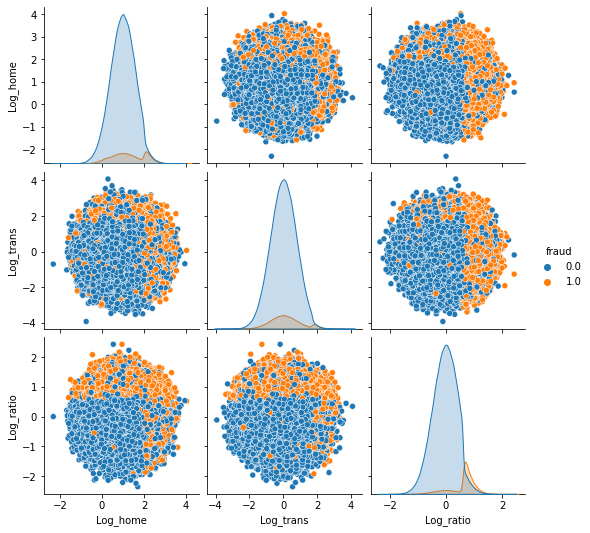

In [10]:
# distribution log normale des features de distance et de ratio
df_bis=df
df_bis['Log_home'] = np.log10(df_bis['distance_from_home'])
df_bis['Log_trans'] = np.log10(df_bis['distance_from_last_transaction'])
df_bis['Log_ratio'] = np.log10(df_bis['ratio_to_median_purchase_price'])
df_bis.drop(['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price'],inplace=True,axis=1)

sns.pairplot(data=df_bis[['Log_home','Log_trans','Log_ratio','fraud']], hue = 'fraud',)
plt.show()

**Analyse des outliers (data points which deviate from the rest of the data)**

Concernant la feature "Distance from home" : elle présente une distribution très étendue de quasi 0 ml à 10K ml avec 75% des distrances <25 ml. Pour autant 2 valeurs isolées sont > 6000 ml dont un cas de fraude. 

Concernant la feature "Distance from last transaction" = elle présente aussi une distribution très étendue 
de quasi 0 ml à 12K ml / 75% < 3 ml). Pour autant 2 valeurs isolées sont > 4000 ml dont aucun cas de fraude 

Même constat pour la feature "ratio d'achat p/ prix médian" (de quasi 0 à 267 / 75% < 2) et 3 valeurs isolées > 150 (dont 1 liée à un cas de fraude).

Qu'ils s'agissent d'outliers n'est pas évident. 

<AxesSubplot:>

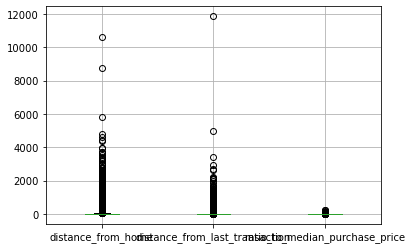

In [19]:
# recherche d'outlier sur les features de distance et ratio
# cettre représentation permet d'identifier plus facilement les points extremes ici limités aux features de distance

df[numerical_columns].boxplot()

**Les features "repeat_retailer","used_chip", "used_pin_number", "online_order" ne prennent comme valeurs que des 0 ou des 1, et on des répartitions très déséquilibrées entre ces deux modalités.**

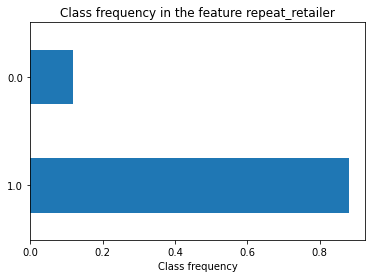

In [11]:
df['repeat_retailer'].value_counts(normalize=True).plot.barh()
plt.xlabel("Class frequency")
_ = plt.title("Class frequency in the feature repeat_retailer")

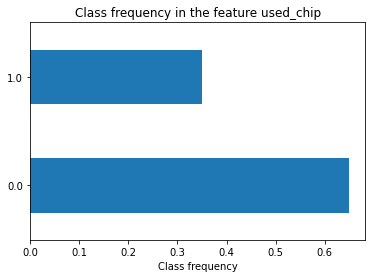

In [12]:
df['used_chip'].value_counts(normalize=True).plot.barh()
plt.xlabel("Class frequency")
_ = plt.title("Class frequency in the feature used_chip")

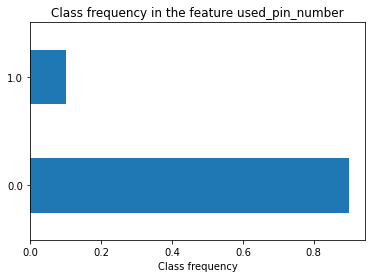

In [13]:
df['used_pin_number'].value_counts(normalize=True).plot.barh()
plt.xlabel("Class frequency")
_ = plt.title("Class frequency in the feature used_pin_number")

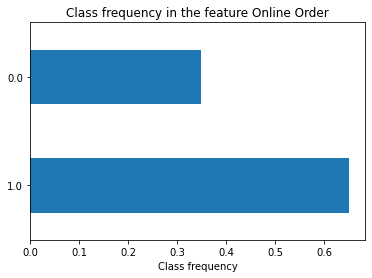

In [14]:
df['online_order'].value_counts(normalize=True).plot.barh()
plt.xlabel("Class frequency")
_ = plt.title("Class frequency in the feature Online Order")

# Recherche de corrélations

## Approche visuelle

**Les représentations 3D de différents groupes de features brutes donnent quelques indications sur de possibles frontrières de décision (avec notamment des cas de fraudes pour les achats en ligne à fort ratio).**

**On complétera** cette analyse par une **recherche de corrélation et une Analyse en Composante Principale** (cf. paragraphe suivant).

In [20]:
df.columns

Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order', 'fraud'],
      dtype='object')

In [21]:
# retrait providoire des valeurs élevées pour mieux visualiser le coeur des données
boolean_mask = (df['distance_from_last_transaction']<4000) & (df['distance_from_home']<4000) & (df['ratio_to_median_purchase_price']<150)

# Applying the boolean filtering
X3D= df[boolean_mask].reset_index(drop=True)
# Extrait de 10% des données pour réduire les temps de calcul
X3D1,X3D2,y3D1,y3D2=train_test_split(X3D[all_features],X3D[target_column],train_size=0.01)

In [22]:
%matplotlib notebook

# commande pour affichage dynamique des graphes 3D

<IPython.core.display.Javascript object>


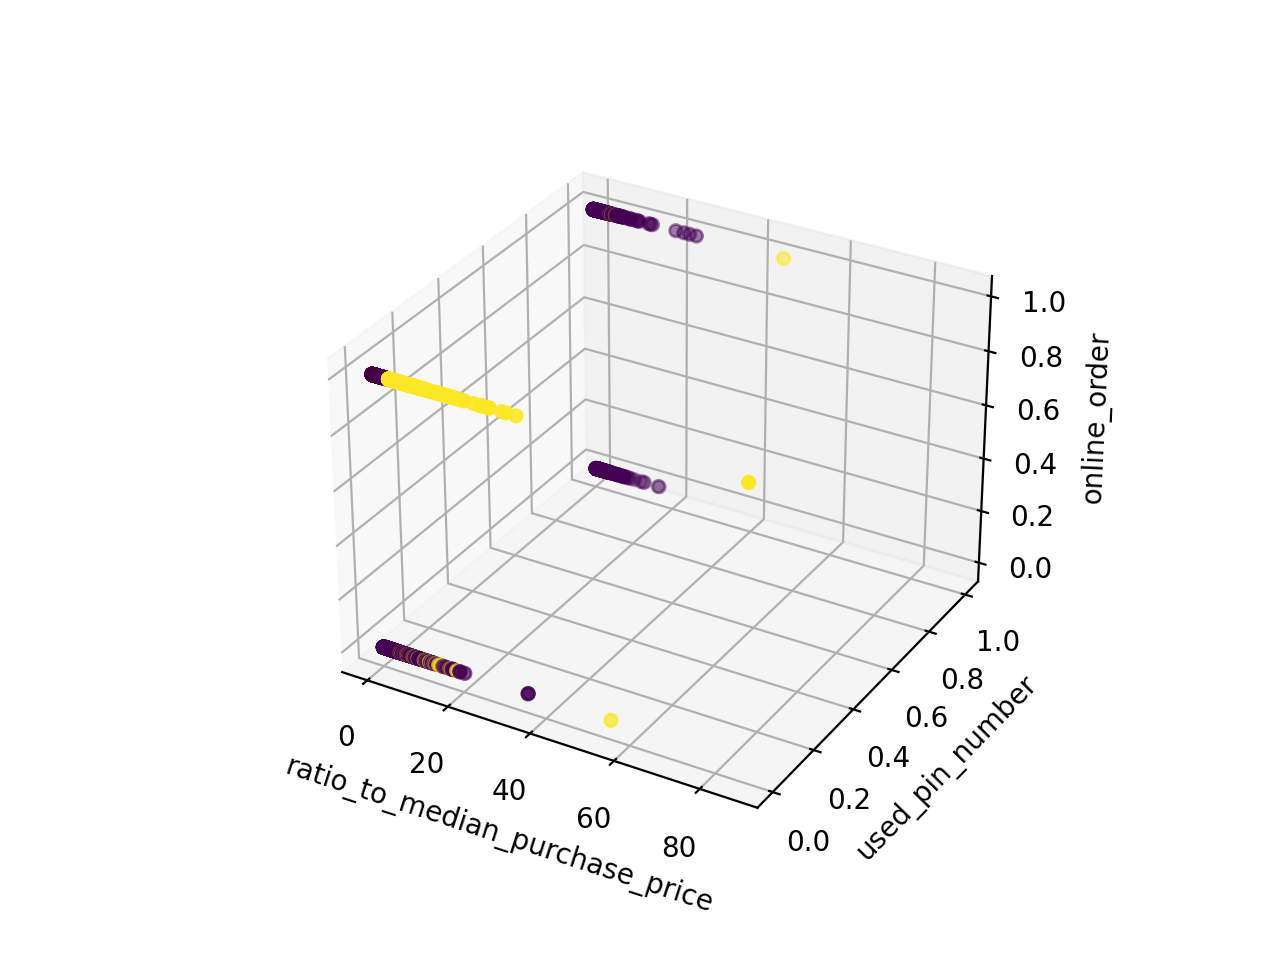

In [23]:
# Indication que de cas de fraudes pour des achats en ligne, sans code pin à des seuils de ratio élevé
#représentation d'un nombre limités de points pour des raisons de temps d'affichage
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X3D1['ratio_to_median_purchase_price'][:10000],
           X3D1['used_pin_number'][:10000],X3D1['online_order'][:10000],c=y3D1[:10000])
ax.set_xlabel(all_features[2])
ax.set_ylabel(all_features[5])
ax.set_zlabel(all_features[6])
plt.show()

<IPython.core.display.Javascript object>


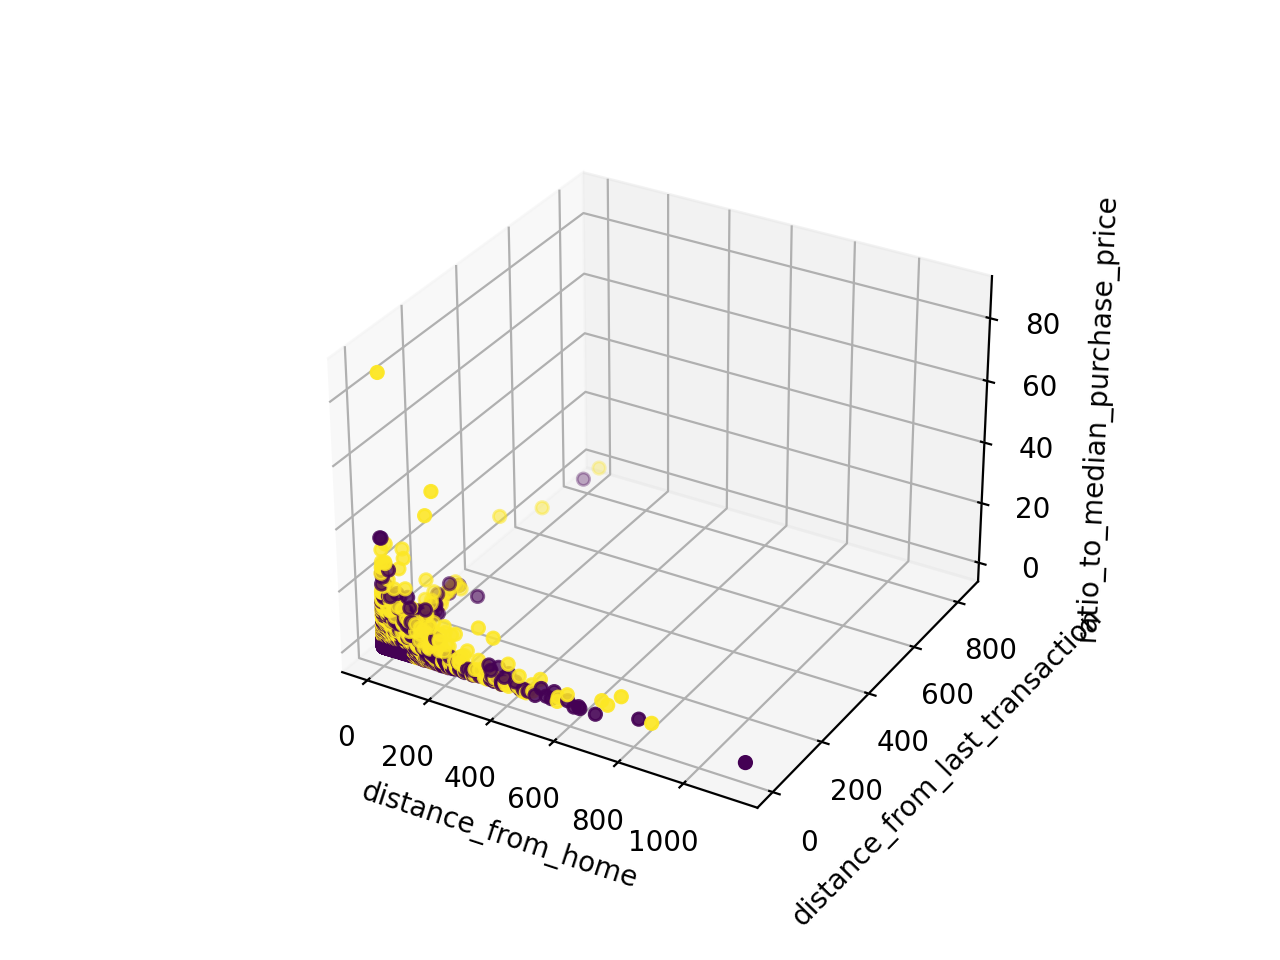

In [24]:
# En revanche aucune séparation évidente entre les features brutes de distance et ratio
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X3D1['distance_from_home'][:10000],X3D1['distance_from_last_transaction'][:10000],
           X3D1['ratio_to_median_purchase_price'][:10000],c=y3D1[:10000])
ax.set_xlabel(all_features[0])
ax.set_ylabel(all_features[1])
ax.set_zlabel(all_features[2])
plt.show()

## Approche par la méthode d'Analyse en Composantes Principales

Explications et codes tirés du cours RCP208 du CNAM (analyse factorielle) et adapté à ce jeu de données.

Les observations à modéliser sont souvent décrites par de nombreuses variables de natures diverses (ce qui est le cas ici). Certaines de ces variables peuvent être redondantes ou n'apporter aucune information prédictive (agir comme du bruit)... ce qui peut avoir un impact négatif sur certaines méthodes de modélisation décisionnelle.

L'ACP devrait nous permettre de mettre en évidence les relations entre variables ou entre groupes de variables.

**L'analyse montre que sans transformation des features, certaines "features" écrasent totalement la variance des autres;alors qu'une fois transformées, toutes les features apparaisent utiles.
On n'aura donc pas besoin de réduction de dimension (après tout il n'y a que 7 features)**.

Ci-dessous n'est présenté que les résultats sur des données transformées. Les différents essais sont détaillés en annexe.

**L'analyse sur différentes parties du jeu de données donne des résultats similaires. Ce qui indique que le jeu de données est assez homogène (pas de concentration de certaines valeurs).**

**Plusieurs modèles de transformation** ont été étudiés (réduit centré, standardscale, minmax, et robustscaler). 

Les deux transformations qui permettent d'équilibrer les contributions 'à la variance' sont le centrage normé (le scale) et le standardscaler sur toutes les features en donnant des résultats proches.

On vérifiera par la suite de ce notenook, le choix du "meilleur scaler" en créant un gridseach sur plusieurs 'scaler' (via un pipe line).

**Point important, la normalisation & centrage des données permet d'identifier 3 groupes de vecteurs propres.**

**La suppression des grandes valeurs sur les features de distances et ratio ne change pas fondalement les regroupements et anti-corrélations (détails en annexe ACP).Ce qui pousse à conserver les grandes valeurs dans le modèle final (et confirme l'absence d'outlier).**

En conclusion, l'ACP centré & normé (ou standard scaler sur toutes les données) donne un résultat plus cohérent avec ce que l'on peut attendre du comportement des acheteurs. 

In [26]:
from sklearn.decomposition import PCA

1iere étape identification des principales composantes et regroupemennt
Les données sont  centrées et réduites mais sans que les potentiels outliers aient été retirés
Cette projection met en évidence de regroupements de features  et des anti-corrélations
- regroupement de 'use chip' avec  'distance from last transaction' 
- regroupement de 'distance from home' et 'repeat retailer'
- regroupement de 'online order' et 'use pin number' en anti-corrélation du groupe 'use chip


[0.16401125 0.1432427  0.143032   0.14284713 0.14264726 0.14251883
 0.12170083]


<IPython.core.display.Javascript object>


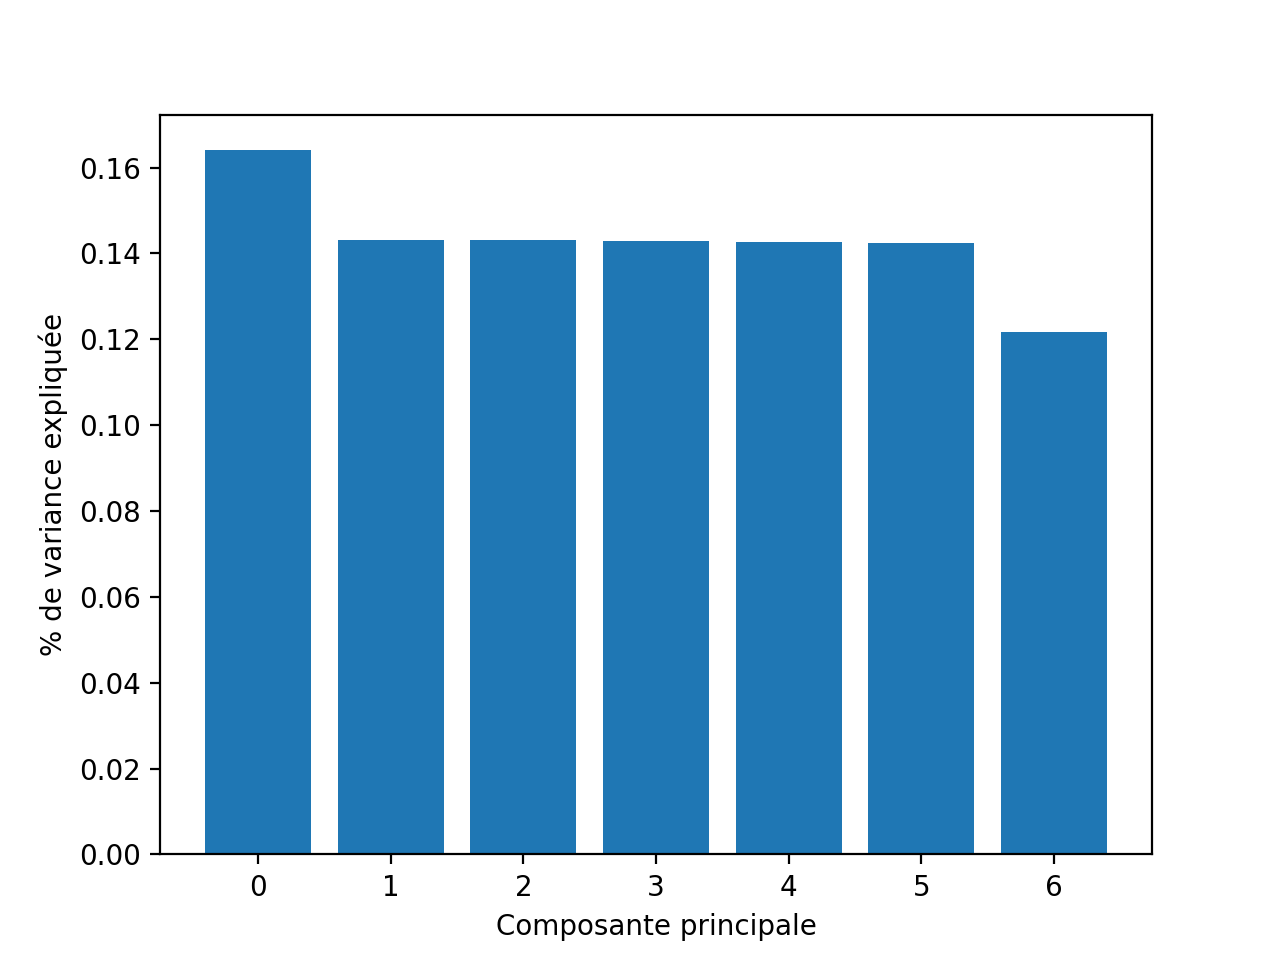

In [27]:
#transformation de centrage et réduction aux variables 
XCR = preprocessing.scale(X3D2)
pcaCR_model= PCA()
pcaCR_model.fit(XCR)

ratios_CR = pcaCR_model.explained_variance_ratio_
print(ratios_CR)

plt.bar(range(len(ratios_CR)), ratios_CR)
plt.xticks(range(len(ratios_CR)))
plt.xlabel("Composante principale")
plt.ylabel("% de variance expliquée")
plt.show()

In [28]:
X_PCA_CR = pcaCR_model.transform(XCR)
#print(X_PCA_CR[:3,:])

<IPython.core.display.Javascript object>


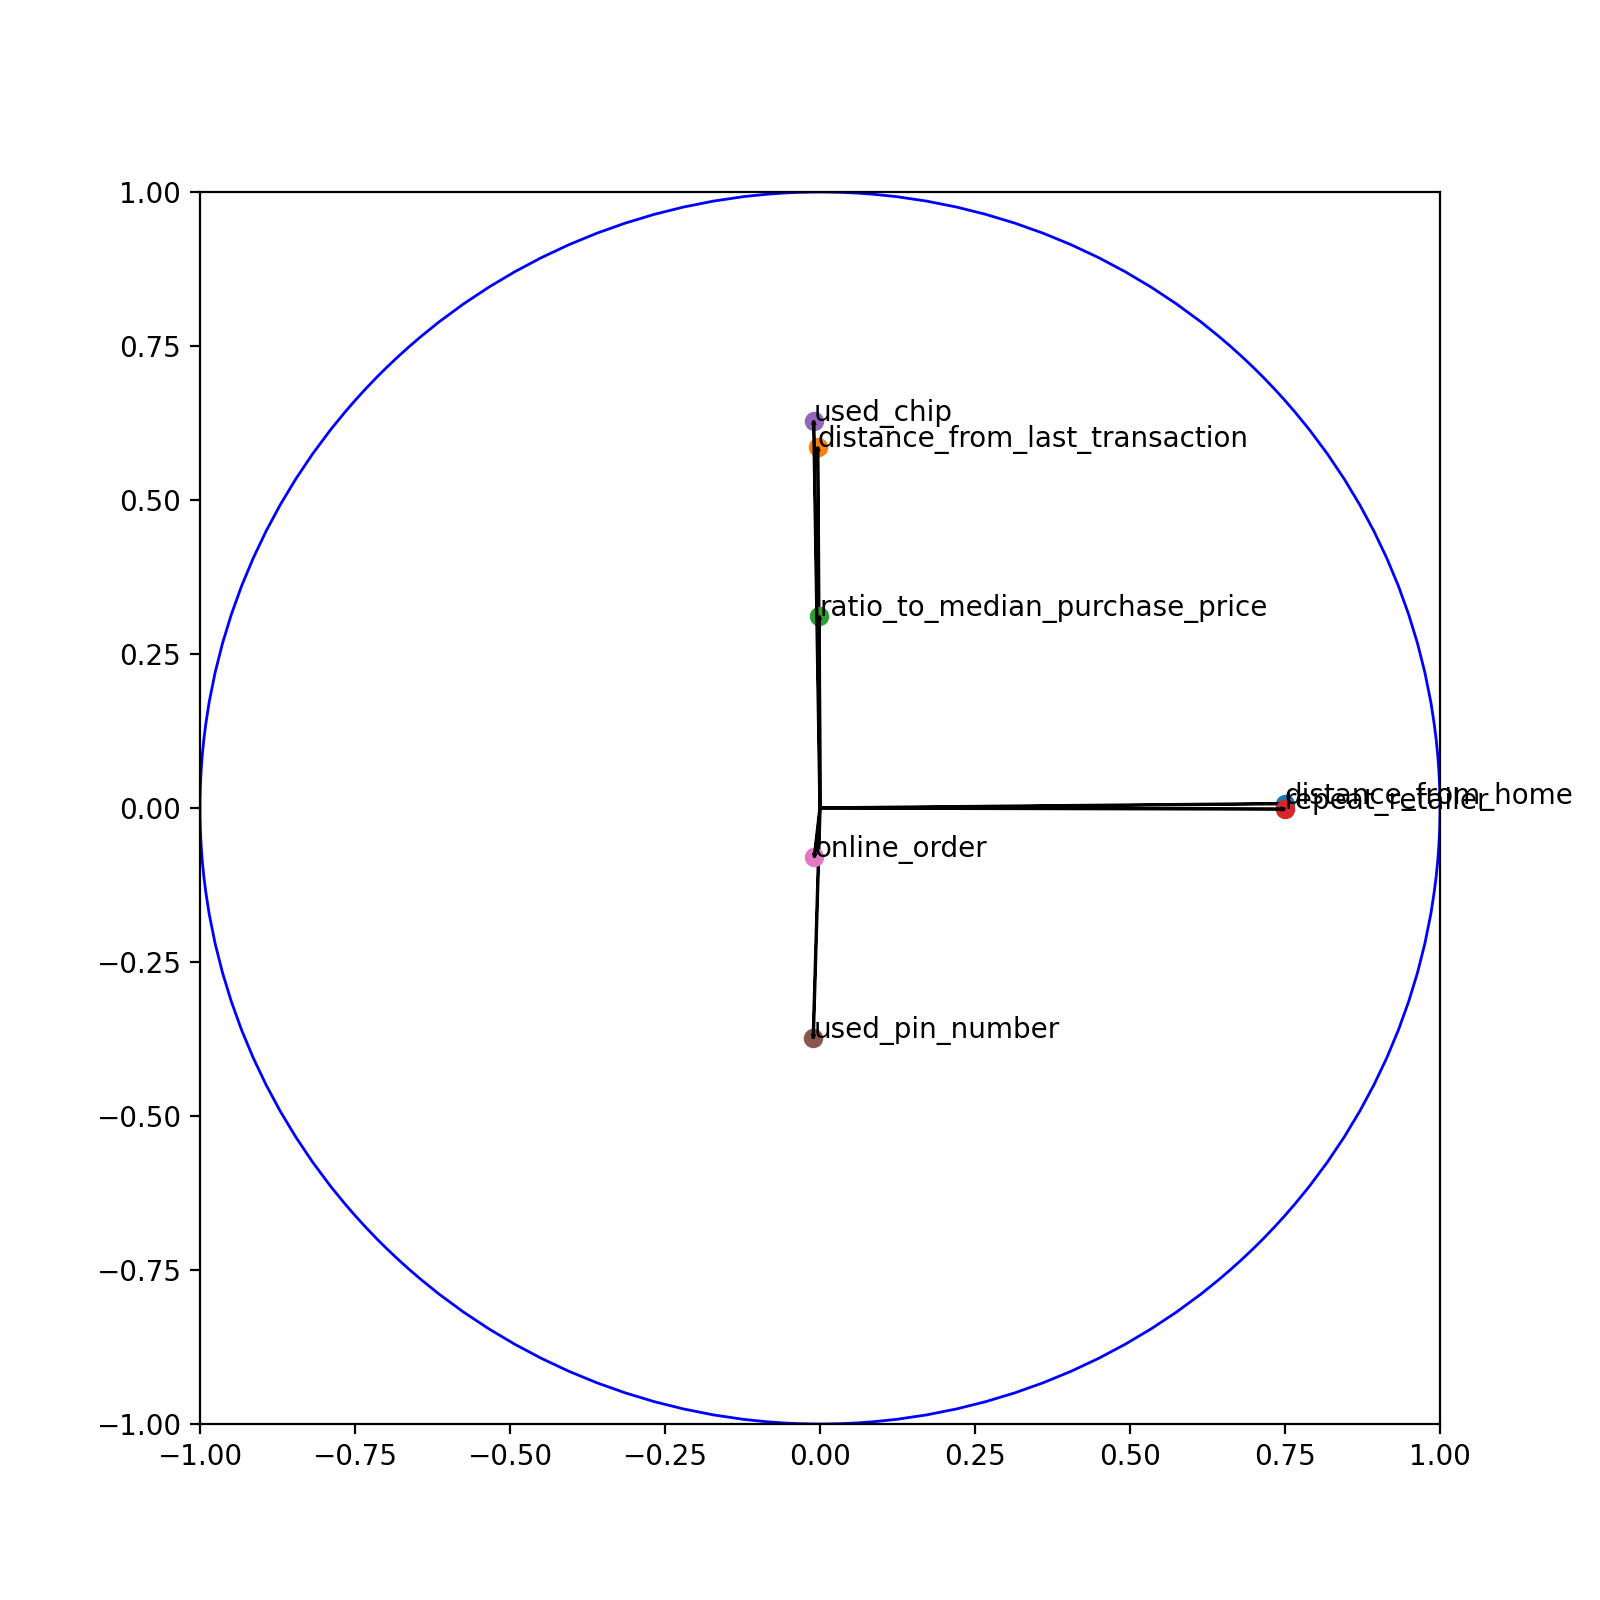

In [29]:
#Affichage des features dans le nouvel espace vectoriel / projection sur les 2 premiers axes principaux
# NB = Plus la projection d’une variable initiale est proche du cercle, plus est contribue à variance sur ce plan

# 3 directions  avec deux groupement et une anticorrélation : 
# distance from last transaction avec  ratio et pin number 
# distance from home & repeat retailer
# et use chip en anti corrélation de ratio

XCR_T = XCR.transpose()
irlambdas = 1/np.sqrt(pcaCR_model.explained_variance_)
mirlambdas = np.diagflat(irlambdas)

projections = (XCR_T.dot(X_PCA_CR)).dot(mirlambdas)/1000000

nomsVars = np.array(all_features)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
cercle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(cercle)

for i in range(len(nomsVars)):
        x,y = projections[i,0], projections[i,1]
        ax.scatter(x,y)
        ax.arrow(0, 0, x, y, shape='full', lw=1, length_includes_head=True)
        ax.text(x, y, nomsVars[i])
plt.show()

In [30]:
df.columns

Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order', 'fraud'],
      dtype='object')

<IPython.core.display.Javascript object>


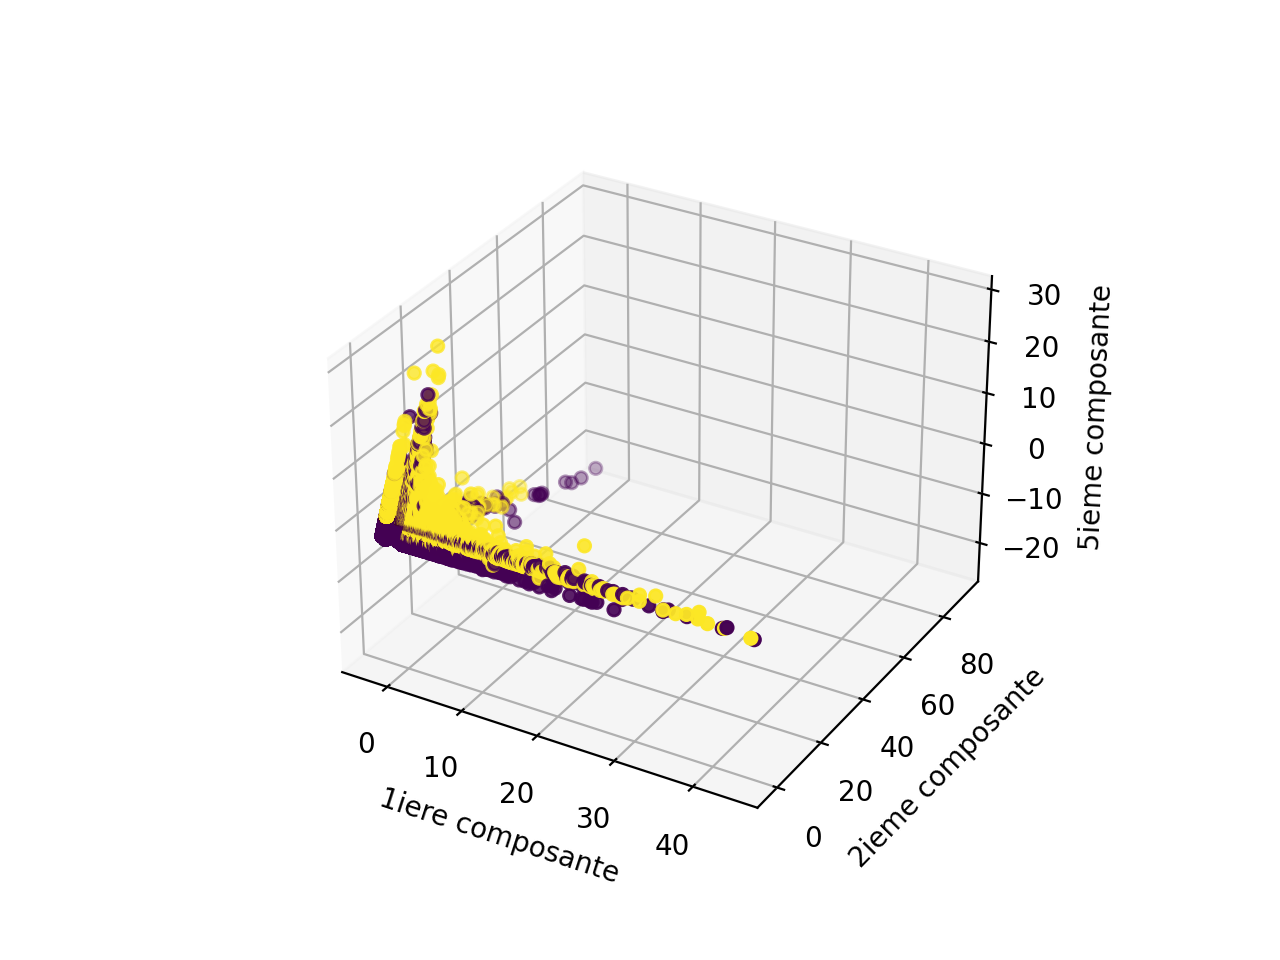

In [31]:
# représentation en 3D des trois principales composantes => frontrière de séparation qui se profile
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_PCA_CR[:,0], X_PCA_CR[:,1], X_PCA_CR[:,5],c=y3D2)
ax.set_xlabel("1iere composante")
ax.set_ylabel("2ieme composante")
ax.set_zlabel("5ieme composante")
plt.show()

### Approche par analyse de corrélation

Deux méthodes ont été utilisée. 

La 1ier montre que le  
- 1ier niv de corrélation de fraude se fait avec le ratio entre prix d'achat et prix médian
- 2ieme niv de corrélation de fraude se fait avec la distance à la maison et l'achat en ligne

On constate une légère anti-corrélation entre fraude et utilisation du code pin (et implicitement utilisation de la carte).

<IPython.core.display.Javascript object>


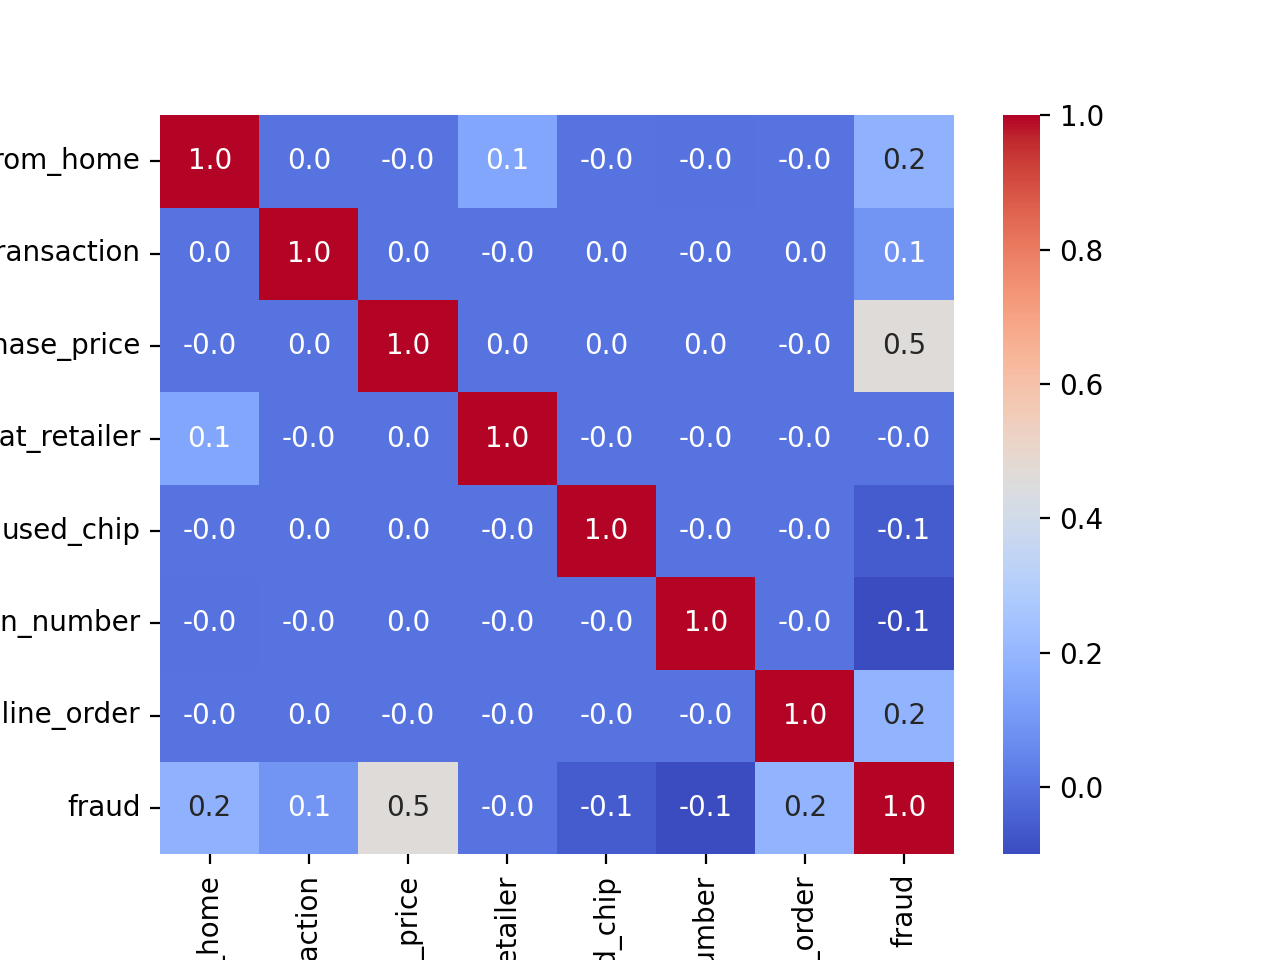

<AxesSubplot:>

In [32]:
#corrélation sur les données brutes

sns.heatmap(df.corr(), cmap='coolwarm',annot=True, fmt=".1f") 

In [33]:
# à retirer à la fin / arrête le mode interactif avec le note book qui gène l'affichage du violon
plt.ioff()

Avec la 2ieme approche, on retrouve cette corrélation :

1)Entre fraude et ratio au prix d'achat selon la distance à la maison et l'achat en ligne

2)Entre fraude d'abord pour des ratios élévés du prix d'achat
   
   En magasin sans code pin et pour des montants > ratio prix d'achat   
  
   En ligne avec ou sans code pin
   
   Et quelques fraudes en ligne sans code pin pour des montants plus faibles

<IPython.core.display.Javascript object>


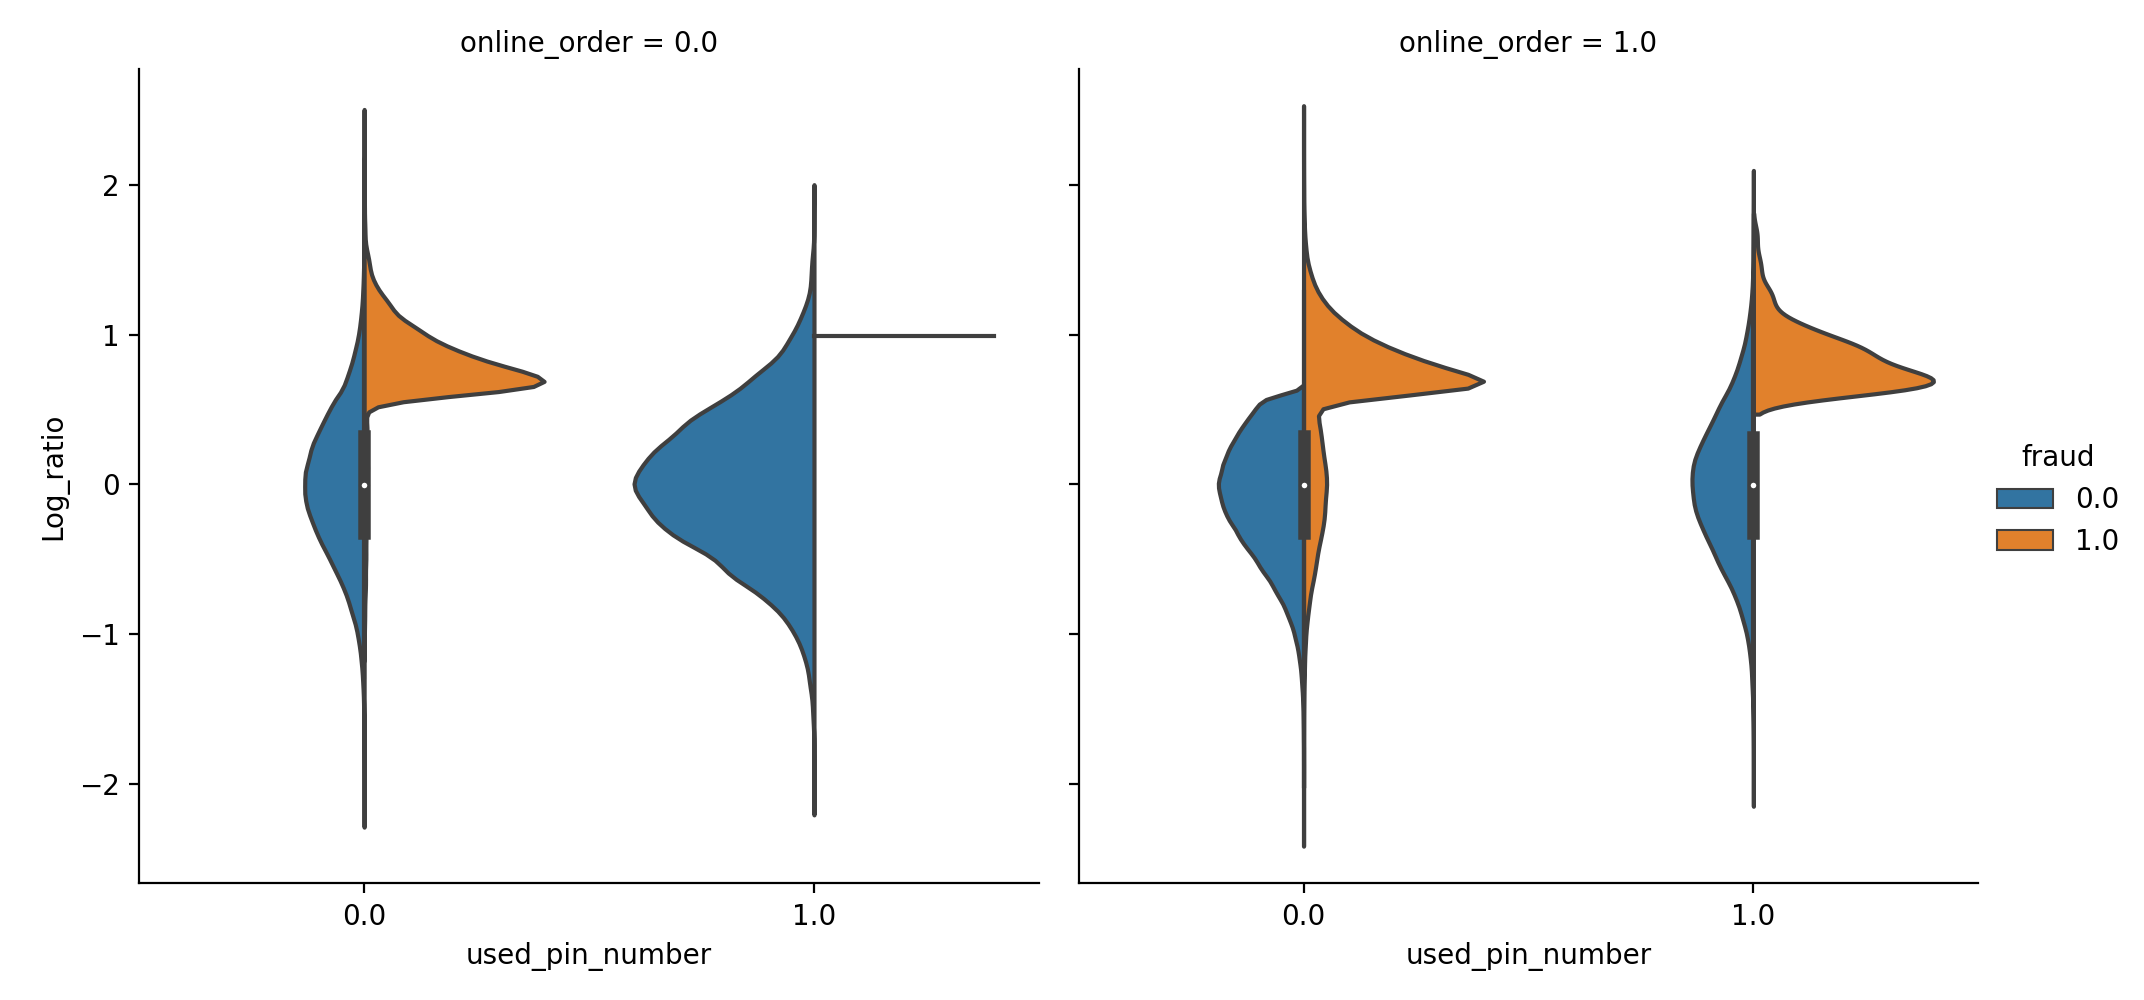

In [34]:

sns.catplot(data=df_bis,x='used_pin_number',y='Log_ratio',hue='fraud',\
            col='online_order',kind="violin",split=True)
plt.show()

# Précautions méthodologiques dans l'élaboration des modèles et qualité des prédictions

**Dans cette partie nous allons nous poser les questions du choix du scoring, des précautions à prendre pour les splits utilisés lors des cross-validation.**

## Stratification des données et tailles des jeux de test et train

Par précaution nous allons **splitter nos données en préservant la fréquence orginale des classes.**

Pour le **split entre train et test, nous utiliserons l'option "stratify=y" pour une partie des classifiers** afin d'évaluer l'impact de cette option (cas du DT, RF, SMOTE et Undersampling avec SGDClassifier

Nous utiliserons **"Stratified K-Folds cross-validator"** (The folds are made by preserving the percentage of samples for each class) lors de la recherche des meilleurs hyperparamètres.**

Pour pouvoir comparer la performance des classifiers, il faut en toute rigueur s'assurer de tailles équivalentes entre les différents essais de classifier. Pour autant, pour réduire les temps de calcul, nous réserverons les grandes tailles aux meilleurs prédicteurs (après un premier tri).

Et enfin concernant le choix des % de split entre train et test, la taille totale du jeu de données étant de 1M, on pourra se permettre de splitter à 50% entre train et test sans risquer (trop) de réduire la qualité d'apprentissage des modèles.

In [5]:
#split our data by preserving the original class frequencies: we want to stratify our data by class.
#evite déformation de la distribution qui fausserait la prédiction

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5)

## Choix de la méthode de scoring 

**Le déséquilibre de fréquence des classes pour la target introduit un biais dans le calcul de l'accuracy par défaut.**

Pour **éviter ce biais nous utiliseront le scoring 'balanced_accuracy'(*), la matrice de confusion et les scores recall & precisions.**

L'annexe "choix de la méthode scoring" détaille ce biais et la méthode utilisée pour me mettre en évidence. 

Nous présentons juste les principaux résultats menée dans cette annexe à l'appui de ce choix  sur la base de deux classifiers :

**Le dummy classifier (1)** avec la strategy ="most frequent" : 
- Le 'balanced_accuracy' est de 0.5, alors qu'il est de 0.9 si on utilise l'accuracy par défaut

Le classifier 'SVC' (sur une petite partie du jeux de données) sans transformation des données:
- Le 'balanced_accuracy' est de 0.557 ± 0.007 , alors qu'il est de 0.918 ± 0.001 avec l'accuracy par défaut

Le classifier 'SVC' (sur une petite partie du jeux de données) avec transformation des données:
- Le 'balanced_accuracy' est de 0.0.958 ± 0.009 , alors qu'il est de 0.992 ± 0.001 avecl'accuracy par défaut

(1) classifier Dummy qui n'utilise que la distribution de la target et sortira une prédiction basée sur la distribution des modalités de la target; ce qui permet d'avoir une 1iere référence de performance en généralisation des futurs modèles. La strategie  "most frequent is called the “chance level for imbalanced classification problems".

(*) définition du balanced_accuracy donnée par "Sklearn" : "The balanced_accuracy_score function computes the balanced accuracy, which avoids inflated performance estimates on imbalanced datasets".
balanced_accuracy=mean(sensitivity,specificity)
où sensitivity =(TP/(TP+FN)) et specificity =(TN/(TN+FP))

## Recherche des hyper paramètres

Le jeu de données étant très important, nous allons **procéder en deux étapes pour identifier les  meilleurs hyperparamètres des classifiers utilisés** :

- identification des plages de valeurs intéressantes via un "RandomizedSearchCV qui donnera également une 1iere estimation du score en généralisation

- tunning plus fin sur une zone de valeurs prometteuses  via un "GridSearchCV" 

A noter que nous incluerons dans la recherche des hyperparamètres, lorsque cela sera possible, la recherche de la meilleure "loss". 

Dans le cas de **classifiers à base de "Decisions Tree" (méthodes assemblistes, nous seront particulièrement vigilants pour éviter tout "over or under-fitting" avec le  choix des hyperparamètres comme "such as max_depth, min_samples_split, or #min_samples_leaf".**

On pourra mettre en place l'option early-stopping dans le classifier "HistGradienBoosting", si les temps de calcul devaient s'avérer trop longs.


## Cas de la "Data preparation"

Il semble difficile d'identifier a priori le meilleur scaler; sachant que ces transformations ne présentent pas les mêmes tolérances aux caractéristiques des données. Par exemple :
- standardscaler -> adaptée pour une feature avec une distribution normalisée
- MinMaxScaler -> sans effet sur outliers & skewness (à vérifier)
- RobustScaler -> peu sensible aux outliers 

On mettra en place une **démarche de comparaison & choix du meilleurs transformer via un pipeline** dans la phase initiale de recherche macro des meilleurs hyperparamètres. 

A noter que les méthodes à base de Decision Tree (et donc méthodes ensemblistes) n'ont besoin que l'on "scale" les données. Juste par précaution et curiosité, nous testerons avec et sans tranformation des données pour nous en assurer.

# Modèle prédictif SGDClassifier avec transformation des données 

**Recherche & identification des principaux hyper paramètre de SGDClassifier.**

Le jeu de données a été splitté en 2, avec 500K pour le train et autant pour le test.

Un fois les hyperparamètres tunnés on obtient un **score sur le train de 0.868 ± 0.005 en moyenne et score en généralisation de 0.871 (un peu mieux que les 0.849 obtenu avec le randomsearch).**

Le score en généralisation sur le test est très légèrement supérieur à celui en apprentissage. Est ce dû à un effet indirect de split du jeu de donnée de train lors de la cross validation (dans le GridSearchCV) entrainant un jeu de donnée plus petit (5 folds sur 500K données, donc un score calculé sur un pseudo jeu de "test" de 100K) que le jeu de test (500K) ?  Après il est également possible des variations dans entre les jeux de train et test soient à l'origine de cet écart..même si cela semble peut probable vu l'analyse initiale de la répartition des données.

**Le modèle n'overfit pas (faible écart avec le score en généralisation) et d'underfit pas non plus puisqu'on est loin du socre de 0.5 obtenu avec le Dummy Classifier.**

**Les precision et recall scores sur le test restent modestes (0.883 et 0.752 respectivement)**; c'est à dire que 88% des cas de fraudes prédites sont correctes et que 75% des vraies fraudes sont réellement prédites.

## Randomsearch du SGDCLassifier avec transformation des données

In [85]:
#split pour évaluer la performance du modèle  50% par défaut sur le train
#à noter que dans cet essai nous n'utilisons pas volontairement l'option stratify=y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5,random_state=42)

### Recherche macro des hyperparamètres

In [61]:
#On incluera la recherche du meilleur transformer dans le randomseach
all_preprocessors = [
    StandardScaler(),
    MinMaxScaler(),
    QuantileTransformer(n_quantiles=100),
    RobustScaler(),
]

In [86]:
#Déclaration du pipeline de base avec les hyperparamètres par défaut pour le classifier
SGDClassifier_model = Pipeline([
            ("preprocessor", all_preprocessors),("classifier", SGDClassifier())])

In [ ]:
#pour récupérer les libellés exacts à déclarer dans le randomsearch
#bien noter le double underscore "_"
SGDClassifier_model.get_params()

In [66]:
#code récupéré du MOOC Inria Machine Learning / ici non utilisé / à supprimer au moment de la rédaction finale
from scipy.stats import loguniform

class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [87]:
%%time

#attention ne pas hesiter n_iter = élevé mais attention impact temps machine lors du fit
#attention scoring "balanced_accuracy" car distribution modalités fraud déséquilibrée
#attention StratifiedKFold pour les splits pour ""preserving the original class frequencies"

param_distributions = {
    'classifier__loss' :('hinge','log_loss','modified_huber'),
    'classifier__penalty': ('l2','l1','elasticnet'),
    'classifier__alpha': (1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100),
    'preprocessor': all_preprocessors,
    'classifier__eta0':loguniform(0.001, 10),
    'classifier__learning_rate': ('optimal','constant','adaptive','invscaling')} 

SGDClassifier_model_random_search = RandomizedSearchCV(
    SGDClassifier_model, param_distributions=param_distributions, n_iter=800, #tenir compte message erreur lors du fit
    cv=cv, verbose=1,scoring='balanced_accuracy',error_score='raise',
)

CPU times: user 2.17 ms, sys: 526 µs, total: 2.69 ms
Wall time: 2.78 ms


In [88]:
%%time

# fit du random search sur SGDClassifier sur 100K données seulement sur le train  (en cause la durée du fit)
SGDClassifier_model_random_search.fit(X_train[:100000], y_train[:100000])

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


/Users/slimkachkachi/.local/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


CPU times: user 51min 44s, sys: 14min 20s, total: 1h 6min 5s
Wall time: 12min 31s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              [StandardScaler(), MinMaxScaler(),
                                               QuantileTransformer(n_quantiles=100),
                                               RobustScaler()]),
                                             ('classifier', SGDClassifier())]),
                   n_iter=800,
                   param_distributions={'classifier__alpha': (1e-06, 1e-05,
                                                              0.0001, 0.001,
                                                              0.01, 0.1...
                                        'classifier__eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7ad14cab20>,
                                        'classifier__learning_rate': ('optimal',
                                                                      'constant',
                                                                      'adaptive',
                                                                      'invscaling'),
                                        'classifier__loss': ('hinge',
                                                             'log_loss',
                                                             'modified_huber'),
                                        'classifier__penalty': ('l2', 'l1',
                                                                'elasticnet'),
                                        'preprocessor': [StandardScaler(),
                                                         MinMaxScaler(),
                                                         QuantileTransformer(n_quantiles=100),
                                                         RobustScaler()]},
                   scoring='balanced_accuracy', verbose=1)

In [89]:
#affichage des meilleurs hyperparamètres trouvés
print(f"The best set of parameters is: "
      f"{SGDClassifier_model_random_search.best_params_}")

The best set of parameters is: {'classifier__alpha': 0.001, 'classifier__eta0': 3.7024611209029272, 'classifier__learning_rate': 'optimal', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1', 'preprocessor': RobustScaler()}


In [ ]:
#contrôle de la structure de .cv_results (dictionnaire python)
#SGDClassifier_model_random_search.cv_results_

In [90]:
#code tiré du cours du MOOC Inria ML
#stockage des données dans DataFrame en vue d'une visualisation des scores
cv_results = pd.DataFrame(SGDClassifier_model_random_search.cv_results_,dtype=float).sort_values(
    "mean_test_score", ascending=False)
#cv_results[["param_classifier__learning_rate","param_classifier__max_leaf_nodes","mean_test_score","std_test_score"]]

/var/folders/gq/_jn8q0_x3p168rscf47_g2b80000gn/T/ipykernel_8414/3950347123.py:3: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  cv_results = pd.DataFrame(SGDClassifier_model_random_search.cv_results_,dtype=float).sort_values(


In [91]:
#pour repérer le nommage des hyperparamètres dans le cv_results 
#cv_results.head(2)
#vérification affichage pour plus de facilité de lecture
cv_results[['rank_test_score','std_test_score','mean_test_score','param_preprocessor','param_classifier__penalty','param_classifier__loss','param_classifier__alpha','param_classifier__eta0','param_classifier__learning_rate']].head(5)

,rank_test_score,std_test_score,mean_test_score,param_preprocessor,param_classifier__penalty,param_classifier__loss,param_classifier__alpha,param_classifier__eta0,param_classifier__learning_rate
640,1.0,0.003919,0.889325,RobustScaler(),l1,modified_huber,0.001000,3.702461,optimal
407,2.0,0.029777,0.883172,StandardScaler(),l1,log_loss,0.000001,1.139438,constant
646,3.0,0.011009,0.880613,RobustScaler(),l1,log_loss,0.000100,0.020109,optimal
743,4.0,0.060929,0.879993,StandardScaler(),l1,hinge,0.000001,0.582227,constant
560,5.0,0.007705,0.877097,RobustScaler(),l1,modified_huber,0.010000,1.212367,optimal


In [92]:
#commande intéressante / permet de transformer la liste de résultat en tableau à deux entrées
#code tiré du cours du MOOC Inria ML & adapté
#ici choix d'affichage du terme de régularisation penalty et de la constante alpha de multiplication de cette régularisation
pivoted_cv_results= cv_results.pivot_table(
    values="mean_test_score", index=["param_classifier__penalty","param_classifier__loss"],
    columns=["param_classifier__alpha"],aggfunc=np.max)

pivoted_cv_results

param_classifier__alpha                           0.000001    0.000010    \
param_classifier__penalty param_classifier__loss                           
elasticnet                hinge                     0.720909    0.831983   
                          log_loss                  0.821389    0.853074   
                          modified_huber            0.844348    0.836551   
l1                        hinge                     0.879993    0.831466   
                          log_loss                  0.883172    0.841363   
                          modified_huber            0.857543    0.810116   
l2                        hinge                     0.824348    0.865924   
                          log_loss                  0.825658    0.858749   
                          modified_huber            0.873180    0.825711   

param_classifier__alpha                           0.000100    0.001000    \
param_classifier__penalty param_classifier__loss                           
elasticnet                hinge                     0.824544    0.792571   
                          log_loss                  0.796865    0.793467   
                          modified_huber            0.802608    0.778535   
l1                        hinge                     0.837542    0.811463   
                          log_loss                  0.880613    0.872084   
                          modified_huber            0.847939    0.889325   
l2                        hinge                     0.834686    0.788594   
                          log_loss                  0.809883    0.767745   
                          modified_huber            0.828068    0.782532   

param_classifier__alpha                           0.010000    0.100000    \
param_classifier__penalty param_classifier__loss                           
elasticnet                hinge                     0.823142    0.551083   
                          log_loss                  0.709144    0.556281   
                          modified_huber            0.747993    0.678669   
l1                        hinge                     0.831380    0.607103   
                          log_loss                  0.666707    0.530607   
                          modified_huber            0.877097    0.607670   
l2                        hinge                     0.716931    0.602514   
                          log_loss                  0.723911    0.611112   
                          modified_huber            0.804167    0.680038   

param_classifier__alpha                           1.000000    10.000000   \
param_classifier__penalty param_classifier__loss                           
elasticnet                hinge                     0.500000    0.500000   
                          log_loss                  0.500432    0.500000   
                          modified_huber            0.543015    0.500000   
l1                        hinge                     0.519194    0.500000   
                          log_loss                  0.500000    0.500000   
                          modified_huber            0.514427    0.500000   
l2                        hinge                     0.525349    0.500098   
                          log_loss                  0.511827    0.501091   
                          modified_huber            0.600407    0.536588   

param_classifier__alpha                           100.000000  
param_classifier__penalty param_classifier__loss              
elasticnet                hinge                     0.500000  
                          log_loss                  0.500000  
                          modified_huber            0.500000  
l1                        hinge                     0.500000  
                          log_loss                  0.500000  
                          modified_huber            0.500000  
l2                        hinge                     0.500000  
                          log_loss                  0.533870  
                      

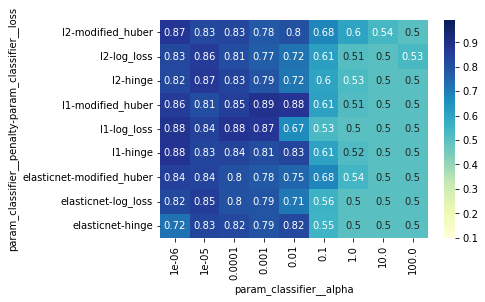

In [93]:
#représentation visuelle du tableau à deux entrées des "scores" 
#A noter qu'il 

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.1,
                 vmax=0.99)
ax.invert_yaxis()

### Tunning des hyperparamètres 
#The best set of parameters is: {'classifier__alpha': 0.001, 'classifier__eta0': 3.7024611209029272, #'classifier__learning_rate': 'optimal', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1', #'preprocessor': RobustScaler()}

In [94]:
#pipeline avec affectation des best params
SGDC_model = Pipeline([
            ("preprocessor", preprocessor_RobScaler),("classifier", SGDClassifier(loss='hinge',
                                                                                  alpha=0.001,
                                                                                  penalty='l1',
                                                                                 eta0=3.702,
                                                                                 learning_rate='optimal'))])

In [ ]:
#pour vérifier que les valeurs des hyper paramètres
#SGDC_model.get_params()

In [266]:
%%time

#tunning fin
#ne pas fitter le modele ici, il s'agit juste de la déclaration du gridsearch
#le fit se fera lors de l'appel du gridsearch dans la cross validation
param_grid = {
    'classifier__alpha': (0.7e-3,0.8e-3,0.9e-3,1e-3,1.1e-3,1.2e-3,1.3e-3),
    'classifier__eta0': (3.6,3.65,3.7,3.75,3.8)
}


SGDC_model_grid_search = GridSearchCV(SGDC_model, param_grid=param_grid,
                                 n_jobs=2, cv=cv,error_score='raise',scoring='balanced_accuracy')

CPU times: user 544 µs, sys: 229 µs, total: 773 µs
Wall time: 691 µs


In [267]:
%%time

# attention partie obligatoire / on refit sur le train mais avec les paramètres tunnés issus du gridsearch

SGDC_model_grid_search.fit(X_train,y_train)

CPU times: user 2.59 s, sys: 310 ms, total: 2.9 s
Wall time: 2min 38s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise',
             estimator=Pipeline(steps=[('preprocessor', RobustScaler()),
                                       ('classifier',
                                        SGDClassifier(alpha=0.0007, eta0=3.65,
                                                      penalty='l1'))]),
             n_jobs=2,
             param_grid={'classifier__alpha': (0.0007, 0.0008, 0.0009, 0.001,
                                               0.0011, 0.0012, 0.0013),
                         'classifier__eta0': (3.6, 3.65, 3.7, 3.75, 3.8)},
             scoring='balanced_accuracy')

In [270]:
%%time

#suite de la méthode nested gridsearch / on fait une cross validation sur le train
#return_estimator=True  pour avoir le score sur chaque split
# jeu de train de 500 K enregistrements

cv_results = cross_validate(
    SGDC_model_grid_search,X_train,y_train, cv=cv, n_jobs=2, return_estimator=True
)

CPU times: user 97.1 ms, sys: 91.6 ms, total: 189 ms
Wall time: 7min 46s


In [294]:
cv_results = pd.DataFrame(cv_results).sort_values("test_score", ascending=False)
cv_test_scores = cv_results['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} ± {cv_test_scores.std():.3f}")

Generalization score with hyperparameters tuning:
0.868 ± 0.005


### Evaluation de la performance du modèle obtenu avec les meilleurs hyperparamètres

In [272]:
%%time

y_predict=SGDC_model_grid_search.predict(X_test)

CPU times: user 49.2 ms, sys: 42.1 ms, total: 91.3 ms
Wall time: 40.5 ms


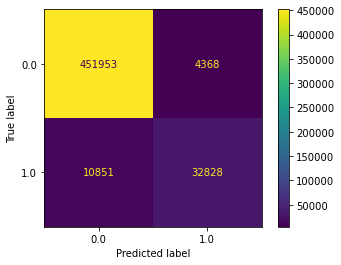

In [273]:
#syntaxe (classifier,data test, target test)

_ = ConfusionMatrixDisplay.from_estimator(SGDC_model_grid_search, X_test, y_test)

In [274]:
# commentaire à supprimer lors de la rédaction finale / exemple lorsque la modalité de la target est char
#precision = precision_score(target_test, target_predicted, pos_label="donated")
#recall = recall_score(target_test, target_predicted, pos_label="donated")

precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)


print(f"Precision score: {precision:.3f}")
print(f"Recall score: {recall:.3f}")

Precision score: 0.883
Recall score: 0.752


In [275]:
# A analyse permet d'avoir la précision et recall par classe
# rappel sur le f1-score = 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict, digits=6))

              precision    recall  f1-score   support

         0.0   0.976554  0.990428  0.983442    456321
         1.0   0.882568  0.751574  0.811821     43679

    accuracy                       0.969562    500000
   macro avg   0.929561  0.871001  0.897631    500000
weighted avg   0.968343  0.969562  0.968449    500000



In [276]:
#synthaxe  balanced_accuracy_score(y_true, y_pred)

score_test=balanced_accuracy_score(y_test, y_predict)

print(f"Balanced Accuracy score en généralisation : {score_test:.3f}")

Balanced Accuracy score en généralisation : 0.871


# Modèle prédictif linear SVC avec  transformation des données 

**Recherche & identification des principaux hyper paramètre de Linear SVC.**

La démarche étant la même que pour le SGDClassifier seuls les résultats sont donnés ici.

**Les scores obtenus lors de la recherche aléatoire des hyperparamètres ayant sont decevants : 0.698 +/- 0.007** (test_score obtenu obtenu via le RandomizedSearchCV = cross validation sur le jeu de train); nous n'avons pas poursuivi la recherche de meilleurs paramètres.

Le code est  néanmoins présenté en annexe "Linear SVC".

# Modèle prédictif SGDClassifier avec 'approximate kernel map'

**Recherche & identification des principaux hyper paramètres de SGDClassifier avec un kernel rbfsample et au jeu de données où les features de distance et ratio ont été tranformées en log.**

Le jeu de données a été splitté en 2, avec 500K pour le train et autant pour le test

Un fois les hyperparamètres tunnés on obtient un **score sur le train de 0.939 ± 0.005 et score en généralisation de 0.937.**

**Le modèle n'overfit pas (faible écart avec le score en généralisation) et d'underfit pas** non plus puisqu'on est loin du socre de 0.5 obtenu avec le Dummy Classifier.

**Les precision et recall scores sur le test sont un peu plus intéressantes avec ce modèles (0.917 et 0.882 respectivement).** 92% des cas fraudes prédites sont correctes et 88% des vraies fraudes sont réellement prédites.

Ce modèle est plus précis que le SGDC avec transformation des données, sans être très performant.

A noter qu'un essai avec des données brutes non transformées a donné un résultat très médiocre à peine meilleur que le Dummy Classifier (0.53 +/- 0.02) (cf. annexe).

## Randomsearch du SGDCLassifier avec 'approximate kernel map' et features log

### Transformation des features de distance et ratio en log

In [157]:
df_log=pd.read_csv("/Users/slimkachkachi/Documents/IA_Dauphine/Machine Learning/Projet_ML(Kaggle)/Dataset/card_transdata.csv")
#df = pd.read_csv("card_transdata.csv")

lognum_columns = [
    "Log_distance_from_home",
    "Log_distance_from_last_transaction",
    "Log_ratio_to_median_purchace_price"    
]

all_log_features=lognum_columns+boolean_columns

In [158]:
df_log['Log_distance_from_home'] = np.log10(df_log['distance_from_home'])
df_log['Log_distance_from_last_transaction'] = np.log10(df_log['distance_from_last_transaction'])
df_log['Log_ratio_to_median_purchace_price'] = np.log10(df_log['ratio_to_median_purchase_price'])

df_log.drop(['distance_from_home','distance_from_last_transaction',
             'ratio_to_median_purchase_price'],inplace=True,axis=1)

X_log=df_log[all_log_features]

### Déclaration du kernel map

In [172]:
#Approximate a RBF kernel feature map using random Fourier features.

from sklearn.kernel_approximation import RBFSampler

rbf_feature = RBFSampler(gamma=1,random_state=13)
X_log_RBF = rbf_feature.fit_transform(X_log)

In [195]:
#Il est intéressant de noter que la dimension de l'espace est passée à 100 (contre 7)!
X_log_RBF.shape

(1000000, 100)

### Recherche macro des meilleurs hyperparamètre par le randomsearch

In [196]:
#split pour évaluer la performance du modèle 
#A noter que l'on pas utilisé l'option "stratify=y".
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log_RBF, y, test_size=0.5,random_state=42)

In [197]:
#Déclaration du classifier

SGDClassifier_model=SGDClassifier()

In [198]:
%%time

#attention ne pas hesiter n_iter = 500 & + (attention impact temps machine)
#attention scoring "balanced_accuracy" car distribution modalités fraud déséquilibrée
#attention StratifiedKFold pour les splits pour ""preserving the original class frequencies"

param_distributions = {
    'loss' :('hinge','log_loss','modified_huber'),
    'penalty': ('l2','l1','elasticnet'),
    'alpha': (1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100),
    'eta0':loguniform(0.001, 10),
    'learning_rate': ('optimal','constant','adaptive','invscaling')} 

SGDClassifier_model_random_search = RandomizedSearchCV(
    SGDClassifier_model, param_distributions=param_distributions, n_iter=800, #tenir compte message erreur lors du fit
    cv=cv, verbose=1,scoring='balanced_accuracy',error_score='raise',n_jobs=2,
)

CPU times: user 1.94 ms, sys: 323 µs, total: 2.26 ms
Wall time: 2.28 ms


In [199]:
%%time

# fit du random search sur SGDClassifier de 15 minutes avec 200K données 
SGDClassifier_model_random_search.fit(X_log_train[:200000], y_train[:200000])

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
CPU times: user 8.38 s, sys: 3.26 s, total: 11.6 s
Wall time: 1h 15s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise', estimator=SGDClassifier(), n_iter=800,
                   n_jobs=2,
                   param_distributions={'alpha': (1e-06, 1e-05, 0.0001, 0.001,
                                                  0.01, 0.1, 1, 10, 100),
                                        'eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7af414e7c0>,
                                        'learning_rate': ('optimal', 'constant',
                                                          'adaptive',
                                                          'invscaling'),
                                        'loss': ('hinge', 'log_loss',
                                                 'modified_huber'),
                                        'penalty': ('l2', 'l1', 'elasticnet')},
                   scoring='balanced_accuracy', verbose=1)

In [200]:
#affichage des meilleurs hyperparamètres trouvés
print(f"The best set of parameters is: "
      f"{SGDClassifier_model_random_search.best_params_}")

#The best set of parameters is: {'alpha': 1e-06, 'eta0': 0.0010824115997490472, 'learning_rate': 'optimal', 
#'loss': 'hinge', 'penalty': 'l1'}

The best set of parameters is: {'alpha': 1e-06, 'eta0': 0.0010824115997490472, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l1'}


In [239]:
#code tiré du cours du MOOC Inria ML
#stockage des données dans DataFrame en vue d'une visualisation des scores
cv_results2 = pd.DataFrame(SGDClassifier_model_random_search.cv_results_,dtype=float).sort_values(
    "mean_test_score", ascending=False)

/var/folders/gq/_jn8q0_x3p168rscf47_g2b80000gn/T/ipykernel_8414/2299800761.py:3: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  cv_results2 = pd.DataFrame(SGDClassifier_model_random_search.cv_results_,dtype=float).sort_values(


In [240]:
#vérification affichage pour plus de facilité de lecture
cv_results2[['rank_test_score','std_test_score','mean_test_score',
            'param_penalty','param_loss',
            'param_alpha','param_eta0',
            'param_learning_rate']].head(5)

,rank_test_score,std_test_score,mean_test_score,param_penalty,param_loss,param_alpha,param_eta0,param_learning_rate
30,1.0,0.005198,0.969143,l1,hinge,0.000001,0.001082,optimal
743,2.0,0.006396,0.968258,l1,hinge,0.000001,9.856687,optimal
639,3.0,0.001400,0.967777,l1,hinge,0.000001,7.070655,adaptive
173,4.0,0.001251,0.967126,l1,hinge,0.000001,3.788202,adaptive
250,5.0,0.000994,0.966941,l1,hinge,0.000001,2.019211,adaptive


In [241]:
#commande intéressante / permet de transformer la liste de résultat en tableau à deux entrées
#code tiré du cours du MOOC Inria ML & adapté
#ici choix du terme de régularisation penalty et de la constante alpha de multiplication de cette régularisation
pivoted_cv_results2= cv_results2.pivot_table(
    values="mean_test_score", index=["param_penalty","param_loss"],
    columns=["param_alpha"],aggfunc=np.max)

pivoted_cv_results2

param_alpha                   0.000001    0.000010    0.000100    0.001000    \
param_penalty param_loss                                                       
elasticnet    hinge             0.958118    0.945343    0.900125    0.745788   
              log_loss          0.955827    0.927699    0.864982    0.683912   
              modified_huber    0.962267    0.952850    0.938593    0.853450   
l1            hinge             0.969143    0.964040    0.931282    0.784820   
              log_loss          0.943010    0.957533    0.914048    0.783598   
              modified_huber    0.962545    0.965240    0.958413    0.889877   
l2            hinge             0.959587    0.949507    0.908881    0.745593   
              log_loss          0.936271    0.924969    0.861957    0.672474   
              modified_huber    0.962216    0.958392    0.926692    0.854579   

param_alpha                   0.010000    0.100000    1.000000    10.000000   \
param_penalty param_loss                                                       
elasticnet    hinge             0.507494         0.5         0.5         0.5   
              log_loss          0.500000         0.5         0.5         0.5   
              modified_huber    0.626920         0.5         0.5         0.5   
l1            hinge             0.500000         0.5         0.5         0.5   
              log_loss          0.500000         0.5         0.5         0.5   
              modified_huber    0.599961         0.5         0.5         0.5   
l2            hinge             0.500000         0.5         0.5         0.5   
              log_loss          0.500000         0.5         0.5         0.5   
              modified_huber    0.745633         0.5         0.5         0.5   

param_alpha                   100.000000  
param_penalty param_loss                  
elasticnet    hinge             0.500000  
              log_loss          0.500000  
              modified_huber    0.500000  
l1            hinge             0.500000  
              log_loss          0.500000  
              modified_huber    0.500000  
l2            hinge             0.500000  
              log_loss          0.500000  
              modified_huber    0.500029

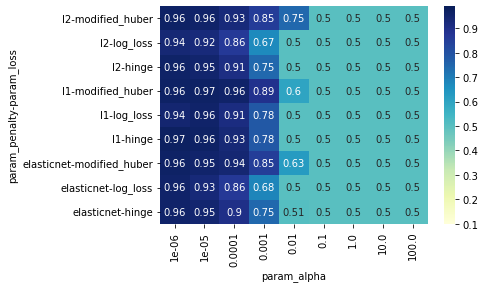

In [242]:
#commande intéressante / permet d'avoir une représentation visuelle du tableau à deux entrées des "scores" 
# il n'y a pas qu'une seule solution
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results2, annot=True, cmap="YlGnBu", vmin=0.1,
                 vmax=0.99)
ax.invert_yaxis()

### Tunning fin des meilleurs hyper paramètres pour SGDClassifier avec kernel et features log

In [ ]:
#The best set of parameters is: {'alpha': 1e-06, 'eta0': 0.0010824115997490472, 'learning_rate': 'optimal', 
#'loss': 'hinge', 'penalty': 'l1'}

In [205]:
#affectation des best params identifiés dans le randomsearch
SGDClassifier_model.set_params(alpha=1e-06,penalty='l1',
                               loss='hinge',eta0=0.0010824115997490472,
                               learning_rate='optimal'
                                            )

SGDClassifier(alpha=1e-06, eta0=0.0010824115997490472, penalty='l1')

In [206]:
%%time

#tunning fin
#déclaration du gridsearch les paramètres doivent coincider avec le transformor
#attention pas de cross validation / juste un fit pour estimer le score 
#limitation du jeu de données
param_grid = {
    'alpha': (0.8e-6,0.9e-6,1e-6,1.1e-6,1.2e-6),
    'eta0': (0.0009,0.00095,0.001,0.0015,0.002)
}


SGDC_model_grid_search = GridSearchCV(SGDClassifier_model, param_grid=param_grid,
                                 n_jobs=2, cv=cv,error_score='raise',scoring='balanced_accuracy',
                                )


CPU times: user 34 µs, sys: 2 µs, total: 36 µs
Wall time: 42.9 µs


In [277]:
%%time

# attention partie obligatoire / on refit sur le train mais avec les paramètres tunnés issus du gridsearch

SGDC_model_grid_search.fit(X_log_train,y_log_train)

CPU times: user 5.27 s, sys: 661 ms, total: 5.93 s
Wall time: 7min 21s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise',
             estimator=Pipeline(steps=[('preprocessor', RobustScaler()),
                                       ('classifier',
                                        SGDClassifier(alpha=0.0007, eta0=3.65,
                                                      penalty='l1'))]),
             n_jobs=2,
             param_grid={'classifier__alpha': (0.0007, 0.0008, 0.0009, 0.001,
                                               0.0011, 0.0012, 0.0013),
                         'classifier__eta0': (3.6, 3.65, 3.7, 3.75, 3.8)},
             scoring='balanced_accuracy')

In [278]:
%%time

#suite de la méthode nested gridsearch / on fait une cross validation sur le modèle pour trouver meilleurs score
#return_estimator=True  pour avoir le score sur chaque split
# jeu de train de 500 K enregistrements

cv_results2 = cross_validate(
    SGDC_model_grid_search,X_log_train,y_log_train, cv=cv, n_jobs=2, return_estimator=True
)

CPU times: user 133 ms, sys: 135 ms, total: 268 ms
Wall time: 19min 43s


In [293]:
cv_results2 = pd.DataFrame(cv_results2).sort_values("test_score", ascending=False)
cv_test_scores2 = cv_results2['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores2.mean():.3f} ± {cv_test_scores2.std():.3f}")

Generalization score with hyperparameters tuning:
0.939 ± 0.005


### Evaluation des performances du modèle avec les meilleurs hyper paramètres

In [280]:
%%time

y_predict=SGDC_model_grid_search.predict(X_log_test)

CPU times: user 289 ms, sys: 262 ms, total: 550 ms
Wall time: 397 ms


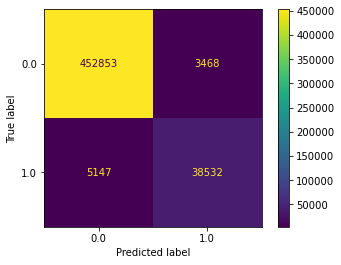

In [281]:

#synthèse (classifier,data test, target test)

_ = ConfusionMatrixDisplay.from_estimator(SGDC_model_grid_search, X_log_test, y_log_test)

In [282]:
# commentaire à supprimer lors de la rédaction finale / exemple lorsque la modalité de la target est char
#precision = precision_score(target_test, target_predicted, pos_label="donated")
#recall = recall_score(target_test, target_predicted, pos_label="donated")

precision = precision_score(y_log_test, y_predict)
recall = recall_score(y_log_test, y_predict)


print(f"Precision score: {precision:.3f}")
print(f"Recall score: {recall:.3f}")

Precision score: 0.917
Recall score: 0.882


In [283]:
# A analyse permet d'avoir la précision et recall par classe
# rappel sur le f1-score = 
from sklearn.metrics import classification_report
print(classification_report(y_log_test, y_predict, digits=6))

              precision    recall  f1-score   support

         0.0   0.988762  0.992400  0.990578    456321
         1.0   0.917429  0.882163  0.899450     43679

    accuracy                       0.982770    500000
   macro avg   0.953095  0.937282  0.945014    500000
weighted avg   0.982530  0.982770  0.982617    500000



In [284]:

score_test=balanced_accuracy_score(y_log_test, y_predict)

print(f"Balanced Accuracy score en généralisation : {score_test:.3f}")

Balanced Accuracy score en généralisation : 0.937


# Modèle prédictif "Decision Tree"

L'algorithme de l'arbre de décision est efficace pour la classification équilibrée, mais il n'est pas performant sur les ensembles de données déséquilibrés. Le déséquilibre peut etre géré en définissant explicitement les poids des caractéristiques des variables. Une façon possible est **d'échanger le ratio des points de données des classes minoritaires et majoritaires**. Cela se fait en passant un paramètre appelé **weights='balanced'** dans le modèle de classificateur d'arbre de décision.

Les arbres de décision et les méthodes d'ensemble **ne nécessitent pas le 'scaling' des caractéristiques** car ils ne sont pas sensibles à la variance des données. Donc, différemment de ce qui est fait dans le modèle précédent, on inclura pas la recherche du meilleur transformer dans le randomseach.

Dans cette section, nous utiliserons ces **hyperparamètres pour réduire l'overfitting** :
* max_depth = profondeur maximale d'un arbre
* min_samples_split = nombre minimum requis pour diviser un nœud interne
* min_samples_leaf = nombre minimum pour qu'un nœud soit une feuille.

**Resultat du modèle :**
Un fois les hyperparamètres tunés on obtient un score sur le train de 1.000 ± 0.000.
Les precision et recall scores sur le test rejoignent de bonne résultants: 1.000 et 1.000 respectivement. Seulement 17 observations dans le jeu de test sont mis-classifiées une fois que le modèle est appliqué. 

In [13]:
#Split pour évaluer la performance du modèle  50% par défaut sur le train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5,random_state=42, stratify=y)

## Modele et recherche macro des hyperparamètres

In [14]:
#Déclaration du pipeline de base avec les hyperparamètres par défaut pour le classifier
#Cela n'inclu pas le preprocessing car les méthodes d'ensemble ne nécessitent pas le 'scaling' des caractéristiques
DecisionTree_model = Pipeline([("classifier", DecisionTreeClassifier(class_weight='balanced', random_state=42))])

In [26]:
#Récupération des libellés exacts à déclarer dans le randomsearch
DecisionTree_model.get_params()

{'memory': None,
 'steps': [('classifier',
   DecisionTreeClassifier(class_weight='balanced', random_state=42))],
 'verbose': False,
 'classifier': DecisionTreeClassifier(class_weight='balanced', random_state=42),
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': 'balanced',
 'classifier__criterion': 'gini',
 'classifier__max_depth': None,
 'classifier__max_features': None,
 'classifier__max_leaf_nodes': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__random_state': 42,
 'classifier__splitter': 'best'}

In [27]:
#Sélection des paramètres
DecisionTree_param_distributions = {
    'classifier__max_depth': randint(1, 30),
     'classifier__min_samples_leaf': randint(1, 15),
 'classifier__min_samples_split': randint(2, 15)} 

In [28]:
## Random search et modèle
DecisionTree_model_random_search = RandomizedSearchCV(
    DecisionTree_model, param_distributions=DecisionTree_param_distributions, n_iter=100,
    cv=cv, verbose=1,scoring='balanced_accuracy',error_score='raise',
)

In [29]:
#Fit du random search 
DecisionTree_model_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise',
                   estimator=Pipeline(steps=[('classifier',
                                              DecisionTreeClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_iter=100,
                   param_distributions={'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A5C67ED460>,
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A5D29C1520>,
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A5D29CF0A0>},
                   scoring='balanced_accuracy', verbose=1)

In [30]:
#Affichage des meilleurs hyperparamètres trouvés
print(f"The best set of parameters is: "
      f"{DecisionTree_model_random_search.best_params_}")

The best set of parameters is: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 6}


## Tuning des hyperparamètres et modele final

In [15]:
#Tunning fin des hyperparamètres autour de resoultant de la random search
DecisionTree_param_grid = {
    'classifier__max_depth': [16, 18, 20, 22],
    # même si le résultat de la random search est 1 pour le min_samples_leaf, 
    #nous augmenterons ce paramètre pour éviter l'overfitting
     'classifier__min_samples_leaf': [5, 10],
 'classifier__min_samples_split': [4, 6, 8]} 

In [16]:
#Final model
DecisionTree_model_grid_search = GridSearchCV(DecisionTree_model, param_grid=DecisionTree_param_grid,
                                 n_jobs=2, cv=cv,error_score='raise',scoring='balanced_accuracy',
                                )

In [17]:
#Cross-validation du model
cv_results_4 = cross_validate(
    DecisionTree_model_grid_search,X_train,y_train, cv=cv, n_jobs=2, return_estimator=True
)

In [18]:
#Fit the model
DecisionTree_model_grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise',
             estimator=Pipeline(steps=[('classifier',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=2,
             param_grid={'classifier__max_depth': [16, 18, 20, 22],
                         'classifier__min_samples_leaf': [5, 10],
                         'classifier__min_samples_split': [4, 6, 8]},
             scoring='balanced_accuracy')

In [19]:
#Affichage des meilleurs hyperparamètres trouvés
print(f"The best set of parameters is: "
      f"{DecisionTree_model_grid_search.best_params_}")

The best set of parameters is: {'classifier__max_depth': 16, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 4}


In [20]:
#Train score
cv_score_4 = cv_results_4['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_score_4.mean():.3f} ± {cv_score_4.std():.3f}")

Generalization score with hyperparameters tuning:
1.000 ± 0.000


## Evaluation du modele

In [21]:
#Appliquer le modèle sur le jeu de test
y_predict_DecisionTree=DecisionTree_model_grid_search.predict(X_test)

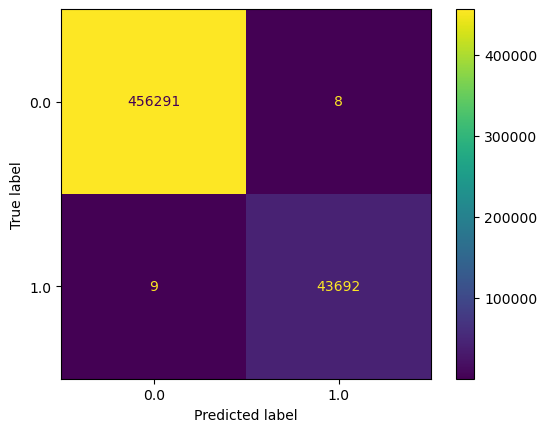

In [22]:
#Confusion Matrix
_ = ConfusionMatrixDisplay.from_estimator(DecisionTree_model_grid_search, X_test, y_test)

In [23]:
#Test scores
precision_4 = precision_score(y_test, y_predict_DecisionTree)
recall_4 = recall_score(y_test, y_predict_DecisionTree)
score_test_4=balanced_accuracy_score(y_test, y_predict_DecisionTree)

print(f"Precision score: {precision_4:.3f}")
print(f"Recall score: {recall_4:.3f}")
print(f"Balanced Accuracy score en généralisation : {score_test_4:.3f}")

Precision score: 1.000
Recall score: 1.000
Balanced Accuracy score en généralisation : 1.000


# Modèle prédictif avec histgradienboosting et transformation des données

**Recherche & identification des principaux hyper paramètre de histgradienboosting.**

Le jeu de données a été splitté en 2, avec 500K pour le train et autant pour le test


**Un fois les hyperparamètres tunnés on obtient un score sur le train de 0.999 ± 0.000 et score en généralisation de 0.999. **

**Le modèle n'overfit pas (faible écart avec le score en généralisation) et d'underfit pas** non plus puisqu'on est loin du socre de 0.5 obtenu avec le Dummy Classifier.

**Les precision et recall scores sont satisfaisants(0.998 et 0.997 respectivement).** 99,8% des cas de fraudes prédites sont correctes et 99,7% des vraies fraudes sont réellement prédites.

Ce modèle est nettement meilleurs sur les SGDClassifier avec transformation des données et le SGDClassifer avec approximatif kernel.

A noter qu'un essai a été réalisé avec une transformation des données (juste pour vérifier les méthodes à base de DT sont insensibles aux différences d'échelles entre les features); les résultats sur les precision et recall suffisement proches pour être considérés comme identiques. 

In [12]:
#split pour évaluer la performance du modèle  50% par défaut sur le train
#A noter que l'on n'a pas utilisé l'option "stratify=y".
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5,random_state=42)

## Recherche macro des meilleurs hyperparamètres du classifier histgradienboosting

In [20]:
HGBC_model = Pipeline([("classifier", HistGradientBoostingClassifier(random_state=13))])

In [ ]:
#pour récupérer la synthaxe des hyperparamètres dans le pipeline
#HGBC_model.get_params()

In [15]:
#code récupéré du MOOC Inria Machine Learning
from scipy.stats import loguniform

class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [23]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
#    'classifier__loss': ('log_loss','binary_crossentropy','auto'),retrait car plusieurs loss sont "deprecated"
    'classifier__l2_regularization': loguniform(1e-6, 1e3),
    'classifier__learning_rate': loguniform(0.001, 10),
    'classifier__max_leaf_nodes': loguniform_int(2, 256),
    'classifier__min_samples_leaf': loguniform_int(1, 100),
    'classifier__max_bins': loguniform_int(2, 255),
}

HGBC_model_random_search = RandomizedSearchCV(
    HGBC_model, param_distributions=param_distributions, n_iter=500, #ici pas hésiter à chercher avec + itérations (500)
    cv=cv, verbose=1,n_jobs=2, scoring='balanced_accuracy',
)


CPU times: user 9.62 ms, sys: 1.86 ms, total: 11.5 ms
Wall time: 10.7 ms


In [24]:
%%time

#pour des raisons d'économie de temps, on utilise qu'une sous partie du jeu de train
# fit du random search sur HighGradientBoostingClassifier quelques minutes avec 200K données
HGBC_model_random_search.fit(X_train[:200000], y_train[:200000])

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
CPU times: user 13.6 s, sys: 3.15 s, total: 16.8 s
Wall time: 20min 37s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('classifier',
                                              HistGradientBoostingClassifier(random_state=13))]),
                   n_iter=500, n_jobs=2,
                   param_distributions={'classifier__l2_regularization': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd8baf91910>,
                                        'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd8bafcd2b0>,
                                        'classifier__max_bins': <__main__.loguniform_int object at 0x7fd8bafd1e20>,
                                        'classifier__max_leaf_nodes': <__main__.loguniform_int object at 0x7fd889870190>,
                                        'classifier__min_samples_leaf': <__main__.loguniform_int object at 0x7fd8bafcd070>},
                   scoring='balanced_accuracy', verbose=1)

In [25]:
#affichage des meilleurs hyperparamètres trouvés
print(f"The best set of parameters is: "
      f"{HGBC_model_random_search.best_params_}")

The best set of parameters is: {'classifier__l2_regularization': 0.23799819930802044, 'classifier__learning_rate': 0.016528167983500996, 'classifier__max_bins': 201, 'classifier__max_leaf_nodes': 82, 'classifier__min_samples_leaf': 3}


In [26]:
#code tiré du cours du MOOC Inria ML
#stockage des données dans DataFrame en vue d'une visualisation des scores
cv_results3 = pd.DataFrame(HGBC_model_random_search.cv_results_,dtype=float).sort_values(
    "mean_test_score", ascending=False)

/var/folders/gq/_jn8q0_x3p168rscf47_g2b80000gn/T/ipykernel_6733/3914368728.py:3: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  cv_results3 = pd.DataFrame(HGBC_model_random_search.cv_results_,dtype=float).sort_values(


In [27]:
#code tiré du MOOC Inria Machine Line/ ici supprimer les param_classifier en identifiant le "__"
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

cv_results3 = cv_results3.rename(shorten_param, axis=1)

In [29]:
#vérification affichage pour plus de facilité de lecture
cv_results3[['rank_test_score','std_test_score','mean_test_score',
            'l2_regularization','learning_rate',
            'max_bins','max_leaf_nodes',
            'min_samples_leaf']].head(5)

,rank_test_score,std_test_score,mean_test_score,l2_regularization,learning_rate,max_bins,max_leaf_nodes,min_samples_leaf
206,1.0,0.000610,0.998232,0.237998,0.016528,201.0,82.0,3.0
76,2.0,0.001063,0.998102,0.037511,0.240825,203.0,23.0,29.0
57,3.0,0.001014,0.997793,0.000176,0.040136,193.0,21.0,1.0
428,4.0,0.000312,0.996893,397.803579,1.763180,133.0,139.0,22.0
343,5.0,0.001347,0.996502,441.516080,0.577678,122.0,117.0,1.0


## Tunning fin des meilleurs hyperparamètres du classifier histgradienboosting

In [30]:
#affectation des best params sans appliquer de transformation sur les données 

HGBC_model = Pipeline([("classifier",HistGradientBoostingClassifier(random_state=13,
                                                      l2_regularization=0.23799819930802044,
                                                      learning_rate=0.016528167983500996,
                                                      max_bins=201,
                                                      max_leaf_nodes=82,min_samples_leaf=3))])

In [31]:
HGBC_model.get_params()

{'memory': None,
 'steps': [('classifier',
   HistGradientBoostingClassifier(l2_regularization=0.23799819930802044,
                                  learning_rate=0.016528167983500996, max_bins=201,
                                  max_leaf_nodes=82, min_samples_leaf=3,
                                  random_state=13))],
 'verbose': False,
 'classifier': HistGradientBoostingClassifier(l2_regularization=0.23799819930802044,
                                learning_rate=0.016528167983500996, max_bins=201,
                                max_leaf_nodes=82, min_samples_leaf=3,
                                random_state=13),
 'classifier__categorical_features': None,
 'classifier__class_weight': None,
 'classifier__early_stopping': 'auto',
 'classifier__interaction_cst': None,
 'classifier__l2_regularization': 0.23799819930802044,
 'classifier__learning_rate': 0.016528167983500996,
 'classifier__loss': 'log_loss',
 'classifier__max_bins': 201,
 'classifier__max_depth': None,
 'classif

In [32]:
%%time

#tunning fin
#attention pas de cross validation / juste un fit pour estimer le score 
#limitation du jeu de données et nombre de paramètre pour réduire les temps de calcul
param_grid = {
    'classifier__l2_regularization': (0.237,0.238,0.239),
    'classifier__max_bins': (200, 201,202),
    'classifier__max_leaf_nodes': (81,82,83),
   'classifier__learning_rate': (0.018,0.016,0.017),
}

HGBC_model_grid_search = GridSearchCV(HGBC_model, param_grid=param_grid,
                                 n_jobs=2, cv=cv,error_score='raise',scoring='balanced_accuracy')

CPU times: user 33 µs, sys: 2 µs, total: 35 µs
Wall time: 42.9 µs


In [33]:
%%time

#refit du modèle sur le jeu de train (l'idée ici est de construire simple avec les bons hyperparamètres pour 
# évaluer sa qualité de prédiction avec tunning des hyperparamètres)
HGBC_model_grid_search.fit(X_train,y_train)

CPU times: user 17 s, sys: 2.45 s, total: 19.5 s
Wall time: 9min 45s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise',
             estimator=Pipeline(steps=[('classifier',
                                        HistGradientBoostingClassifier(l2_regularization=0.23799819930802044,
                                                                       learning_rate=0.016528167983500996,
                                                                       max_bins=201,
                                                                       max_leaf_nodes=82,
                                                                       min_samples_leaf=3,
                                                                       random_state=13))]),
             n_jobs=2,
             param_grid={'classifier__l2_regularization': (0.237, 0.238, 0.239),
                         'classifier__learning_rate': (0.018, 0.016, 0.017),
                         'classifier__max_bins': (200, 201, 202),
                         'classifier__max_leaf_nodes': (81, 82, 83)},
             scoring='balanced_accuracy')

In [36]:
%%time

#suite de la méthode nested gridsearch / on fait une cross validation sur le modèle
#return_estimator=True  pour avoir le score sur chaque split
# jeu de train de 500 K enregistrements

cv_results3 = cross_validate(
    HGBC_model_grid_search,X_train,y_train, cv=cv, n_jobs=2, return_estimator=True
)

CPU times: user 159 ms, sys: 113 ms, total: 273 ms
Wall time: 1h 48min 27s


In [37]:
cv_results3 = pd.DataFrame(cv_results3).sort_values("test_score", ascending=False)
cv_test_scores3 = cv_results3['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores3.mean():.3f} ± {cv_test_scores3.std():.3f}")

Generalization score with hyperparameters tuning:
0.999 ± 0.000


## Evaluation des performances du modèle histgradienboosting avec ses meilleurs hyperparamètres

In [38]:
%%time

#prédiction sur le jeu de test
y_predict=HGBC_model_grid_search.predict(X_test)

CPU times: user 4.51 s, sys: 444 ms, total: 4.95 s
Wall time: 672 ms


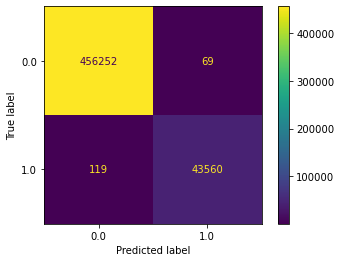

In [39]:
#synthèse (classifier,data test, target test)

_ = ConfusionMatrixDisplay.from_estimator(HGBC_model_grid_search, X_test, y_test)

In [40]:
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)


print(f"Precision score: {precision:.3f}")
print(f"Recall score: {recall:.3f}")

Precision score: 0.998
Recall score: 0.997


In [41]:
# A analyse permet d'avoir la précision et recall par classe
# rappel sur le f1-score = 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict, digits=6))

              precision    recall  f1-score   support

         0.0   0.999739  0.999849  0.999794    456321
         1.0   0.998418  0.997276  0.997847     43679

    accuracy                       0.999624    500000
   macro avg   0.999079  0.998562  0.998820    500000
weighted avg   0.999624  0.999624  0.999624    500000



In [42]:

score_test=balanced_accuracy_score(y_test, y_predict)

print(f"Balanced Accuracy score en généralisation : {score_test:.3f}")

Balanced Accuracy score en généralisation : 0.999


# Modèle prédictif Random Forest

Dans un modele de forêt aléatoire, etant donné que chaque arbre est construit à partir d'un échantillon bootstrap, la distribution des classes dans l'échantillon de données sera différente pour chaque arbre. Il peut donc être intéressant de modifier la pondération des classes en fonction de la distribution des classes dans chaque échantillon bootstrap, en définissant l'argument **class_weight** à la valeur **'balanced_subsample'**.

Comme le modele Random Forest se base sur des arbres de décision il **ne nécessitent pas le 'scaling' des caractéristiques**.

Dans cette section, nous utiliserons ces *hyperparamètres*:
* max_depth = profondeur maximale d'un arbre
* min_samples_split = nombre minimum requis pour diviser un nœud interne
* min_samples_leaf = nombre minimum pour qu'un nœud soit une feuille.
* n_estimators = nombre d'arbres dans la forêt.

**Resultat du modèle :**
Un fois les hyperparamètres tunés on obtient un score sur le train de 1.000 ± 0.000.
Les precision et recall scores sur le test rejoignent de bonne résultants: 1.000 et 1.000 respectivement. Seulement 8 observations dans le jeu de test sont mis-classifiées une fois que le modèle est appliqué (résultat meilleur que l'arbre de décision)

In [6]:
#Split pour évaluer la performance du modèle  50% par défaut sur le train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=42, stratify=y)

## Modele et recherche macro des hyperparamètres

In [7]:
#Déclaration du pipeline de base avec les hyperparamètres par défaut pour le classifier
#Cela n'inclu pas le preprocessing car les méthodes d'ensemble ne nécessitent pas le 'scaling' des caractéristiques
RandomForest_model = Pipeline([("classifier", RandomForestClassifier(class_weight='balanced_subsample', random_state=42,
                                                                    min_samples_leaf=5, min_samples_split=4))])

In [8]:
#Tunning fin des hyperparamètres autour de resoultant de la random search
RandomForest_param_grid = {
    'classifier__max_depth': [16, 20],
    'classifier__n_estimators': [60, 100]
} 

In [9]:
#Final model
RandomForest_model_grid_search = GridSearchCV(RandomForest_model, param_grid=RandomForest_param_grid,
                                 n_jobs=2, cv=cv,error_score='raise',scoring='balanced_accuracy' )

In [10]:
#Fit the model
RandomForest_model_grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise',
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(class_weight='balanced_subsample',
                                                               min_samples_leaf=5,
                                                               min_samples_split=4,
                                                               random_state=42))]),
             n_jobs=2,
             param_grid={'classifier__max_depth': [16, 20],
                         'classifier__n_estimators': [60, 100]},
             scoring='balanced_accuracy')

In [12]:
#Cross-validation du model
cv_results_5 = cross_validate(
    RandomForest_model_grid_search, 
    X_train,y_train, cv=cv, n_jobs=2, return_estimator=True
)

In [13]:
#Train score
cv_score_5 = cv_results_5['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_score_5.mean():.3f} ± {cv_score_5.std():.3f}")

Generalization score with hyperparameters tuning:
1.000 ± 0.000


## Evaluation du modele

In [14]:
#Appliquer le modèle sur le jeu de test
y_predict_RandomForest=RandomForest_model_grid_search.predict(X_test)

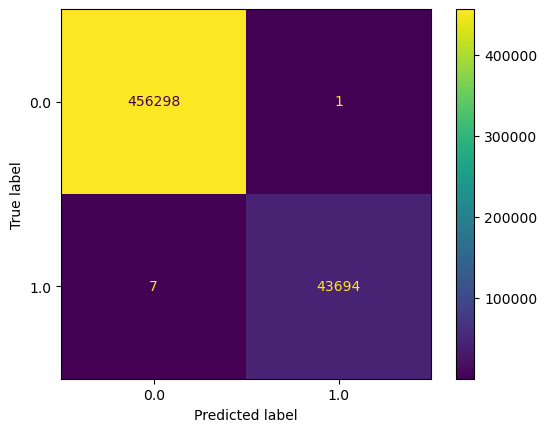

In [15]:
#Confusion Matrix
_ = ConfusionMatrixDisplay.from_estimator(RandomForest_model_grid_search, X_test, y_test)

In [17]:
#Test scores
precision_5 = precision_score(y_test, y_predict_RandomForest)
recall_5 = recall_score(y_test, y_predict_RandomForest)
score_test_5=balanced_accuracy_score(y_test, y_predict_RandomForest)

print(f"Precision score: {precision_5:.3f}")
print(f"Recall score: {recall_5:.3f}")
print(f"Balanced Accuracy score en généralisation : {score_test_5:.3f}")

Precision score: 1.000
Recall score: 1.000
Balanced Accuracy score en généralisation : 1.000


#  Modème prédictif avec 'undersampling' and 'oversampling'

D'autres approches pour résoudre le problème du déséquilibre des classes consiste à rééchantillonner l'ensemble de données d'apprentissage. Les deux principales approches consistent à supprimer des exemples de la classe majoritaire, le sous-échantillonnage (undersampling), et à dupliquer des exemples de la classe minoritaire, ce que l'on appelle le suréchantillonnage (oversampling).

On appliquera le modèle SGDClassifier avec transformation des données pour comprendre si il performe mieux avec une proportion de deux classes du 50%.

## Oversampling - SMOTE

SMOTE sélectionne une paire d'observations de classe minoritaire, puis en créant un point synthétique qui se trouve sur la ligne reliant ces deux observations. Dans la sélection des points minoritaires peut prendre des points qui sont des valeurs aberrantes. ADASYN, BorderLine SMOTE, KMeansSMOTE, SVMSMOTE sont quelques-unes des stratégies permettant de sélectionner de meilleurs points minoritaires.

Nous procéderons à un suréchantillonnage après avoir divisé les ensembles de données de formation et de validation, afin d'éviter que les informations du jeu de test ne se retrouvent dans la formation du modèle (jeu de train).

**Resultat du modèle :**

Un fois les hyperparamètres tunés on obtient un score sur le train de 0.937 ± 0.029 et sur le test de 0.936 (pas d'overfitting).

Le recall scores sur le test est de 0.961, c'est à dire que 96% des vraies fraudes sont réellement prédites.
En revanche, la precision de 50% est mauvaise (50% de fraudes detectees ne le sont pas). Piste d'explication:L'utilisation de SMOTE consiste à créer des observations de la classe minoritaire (fraudes) dans le jeu de train, qui n'ont pas d'équivalence dans le jeu de test. Donc le modèle va détecter plus de cas de fraude que si il avait été entraîné sur un jeu non transformé, d'où plus de faux négatifs et une précision plus faible (0.506 vs. 0.883 du SGDClassifier sans oversampling)

In [10]:
#Split pour évaluer la performance du modèle 50% par défaut sur le train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=42, stratify=y)

In [6]:
#Percentage des classes
y_train.value_counts() / y_train.count()

0.0    0.912596
1.0    0.087404
Name: fraud, dtype: float64

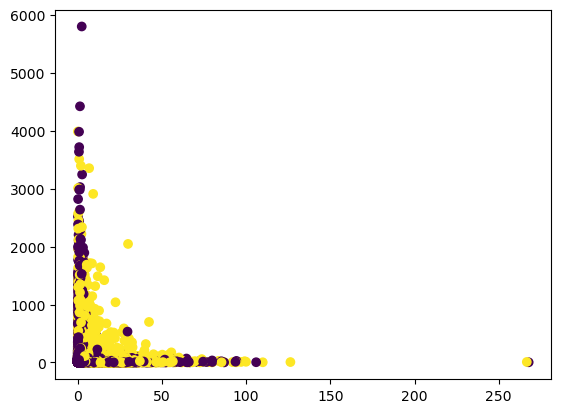

In [7]:
#Original train set
fig, ax = plt.subplots()
ax.scatter(X_train['ratio_to_median_purchase_price'], X_train['distance_from_home'],c = y_train )
plt.show()

In [8]:
# Creation du nouveau jeu de train avec Oversampling
sm = SMOTE()
X_train_OVER, y_train_OVER = sm.fit_resample(X_train, y_train)

#Percentage des classes
y_train_OVER.value_counts() /y_train_OVER.count()

0.0    0.5
1.0    0.5
Name: fraud, dtype: float64

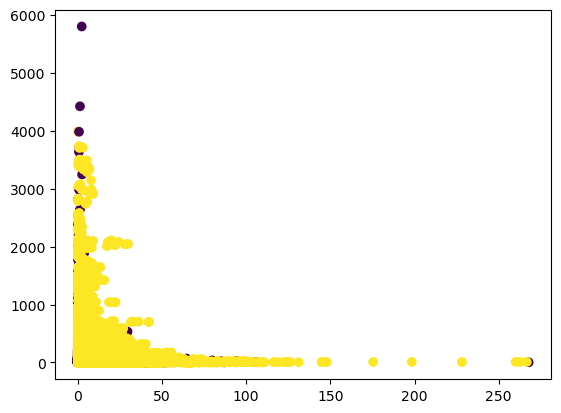

In [9]:
# Visualisation du nouveau jeu de train
fig, ax = plt.subplots()
ax.scatter(X_train_OVER['ratio_to_median_purchase_price'], X_train_OVER['distance_from_home'],c = y_train_OVER)
plt.show()

In [10]:
#Déclaration du pipeline de base avec les hyperparamètres pour le SGDClassifier (chapitre 6.1.2)
SGDClassifierOVER_model= Pipeline([
            ("preprocessor", RobustScaler()),("classifier", SGDClassifier(alpha=1e-06,penalty='l1',
                               loss='hinge',eta0=0.0010824115997490472,
                               learning_rate='optimal'))])

In [11]:
#Fit the model
SGDClassifierOVER_model.fit(X_train_OVER, y_train_OVER)

Pipeline(steps=[('preprocessor', RobustScaler()),
                ('classifier',
                 SGDClassifier(alpha=1e-06, eta0=0.0010824115997490472,
                               penalty='l1'))])

In [12]:
#Cross-validation du model
cv_results_6 = cross_validate(
    SGDClassifierOVER_model,X_train,y_train, cv=cv, n_jobs=2, return_estimator=True
)

In [13]:
#Train score
cv_score_6 = cv_results_6['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_score_6.mean():.3f} ± {cv_score_6.std():.3f}")

Generalization score with hyperparameters tuning:
0.937 ± 0.029


In [14]:
#Appliquer le modèle sur le jeu de test
y_predict_SGDClassifierOVER=SGDClassifierOVER_model.predict(X_test)

In [15]:
#Test scores
precision_6 = precision_score(y_test, y_predict_SGDClassifierOVER)
recall_6 = recall_score(y_test, y_predict_SGDClassifierOVER)
score_test_6=balanced_accuracy_score(y_test, y_predict_SGDClassifierOVER)

print(f"Precision score: {precision_6:.3f}")
print(f"Recall score: {recall_6:.3f}")
print(f"Balanced Accuracy score en généralisation : {score_test_6:.3f}")

Precision score: 0.506
Recall score: 0.961
Balanced Accuracy score en généralisation : 0.936


## Undersampling - RandomUnderSampler

**Resultat du modèle :**

Un fois les hyperparamètres tunés on obtient un score sur le train de 0.945 ± 0.014 et sur le test de 0.907(pas d'overfitting).

Le recall scores sur le test est de 0.914, c'est à dire que 91 des vraies fraudes sont réellement prédites (légèrement moins bon que l'oversampling). En revanche, la précision de 45.6% est encore plus mauvaise. Piste d'explication: L'utilisation de l'undersampling consiste à retirer des observations de la classe majoritaire(non-fraudes) dans le jeu de train. Donc le modèle est entraîné dans un nombre de cas réduits d'absence de fraude. Donc dans le jeu de test le modèle ne sera pas capable de le reconnaître comme des absence de fraude, d'où plus de faux négatifs et une précision plus faible (0.456 vs. 0.883 du SGDClassifier sans oversampling).

In [11]:
# Count des classes du jeu de train
y_train.value_counts()

0.0    456298
1.0     43702
Name: fraud, dtype: int64

In [12]:
# Creation du nouveau jeu de train avec RandomUnderSampler
under = RandomUnderSampler(sampling_strategy=0.5)
X_train_UNDER, y_train_UNDER = under.fit_resample(X_train, y_train)

#Count des nouvelles classes
y_train_UNDER.value_counts()

0.0    87404
1.0    43702
Name: fraud, dtype: int64

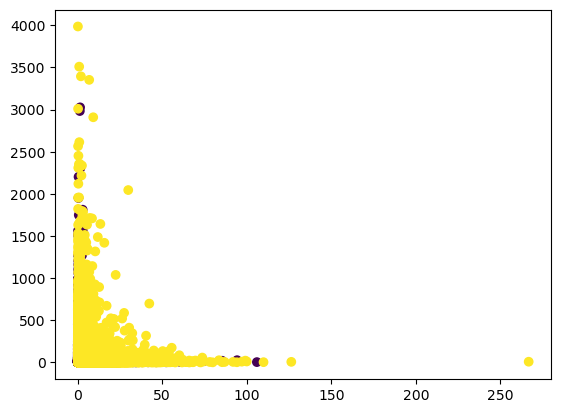

In [13]:
# Visualisation du nouveau jeu de train
fig, ax = plt.subplots()
ax.scatter(X_train_UNDER['ratio_to_median_purchase_price'], X_train_UNDER['distance_from_home'],c = y_train_UNDER)
plt.show()

In [14]:
#Déclaration du pipeline de base avec les hyperparamètres pour le SGDClassifier (chapitre 6.1.2)
SGDClassifierUNDER_model= Pipeline([
            ("preprocessor", RobustScaler()),("classifier", SGDClassifier(alpha=1e-06,penalty='l1',
                               loss='hinge',eta0=0.0010824115997490472,
                               learning_rate='optimal'))])

In [15]:
#Fit the model
SGDClassifierUNDER_model.fit(X_train_UNDER, y_train_UNDER)

Pipeline(steps=[('preprocessor', RobustScaler()),
                ('classifier',
                 SGDClassifier(alpha=1e-06, eta0=0.0010824115997490472,
                               penalty='l1'))])

In [16]:
#Cross-validation du model
cv_results_7 = cross_validate(
    SGDClassifierUNDER_model,X_train,y_train, cv=cv, n_jobs=2, return_estimator=True
)

In [17]:
#Train score
cv_score_7 = cv_results_7['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_score_7.mean():.3f} ± {cv_score_7.std():.3f}")

Generalization score with hyperparameters tuning:
0.945 ± 0.014


In [18]:
#Appliquer le modèle sur le jeu de test
y_predict_SGDClassifierUNDER=SGDClassifierUNDER_model.predict(X_test)

In [19]:
#Test scores
precision_7 = precision_score(y_test, y_predict_SGDClassifierUNDER)
recall_7 = recall_score(y_test, y_predict_SGDClassifierUNDER)
score_test_7=balanced_accuracy_score(y_test, y_predict_SGDClassifierUNDER)

print(f"Precision score: {precision_7:.3f}")
print(f"Recall score: {recall_7:.3f}")
print(f"Balanced Accuracy score en généralisation : {score_test_7:.3f}")

Precision score: 0.465
Recall score: 0.914
Balanced Accuracy score en généralisation : 0.907


# Synthèse & Conclusion

**Les modèles les plus performants sont les modèles “ensemblistes” tant sur l’accuracy que sur les “precisions” et “recall”.** Mais il a fallu tenir compte du déséquilibre entre les deux classes de la target pour obtenir ces résultats avec : 
Pour le Decision tree : utilisation weights='balanced' dans le modèle
Pour le Random Forest: utilisation weights='balanced_subsample’ 
Pour le HistGradienBoosting : pas de pondération des classes lors du split initial entre train & test, ce qui pourrait expliquer un score un peu moins bon de ce modèle.

**Les modèles SGDClassifier malgré des transformations ou approximations “kernel” ont été moins efficaces** que les méthodes ensemblistes dans le cas de déséquilibre entre classe (de la target); malgré un travail de transformation des données.

**Et les méthodes d’oversampling et undersampling une fois les données scalées (Robust Scaler) associées au SGDClassifier se sont avérées particulièrement sous performantes** (avec en particulier des “precisions score” très mauvaises).

A noter que l’on n'a pas eu à traiter les données en amont, manifestement elles avaient été toutes préparées (pas donnée manquante, pas de doublon, pas d’outlier manifeste).

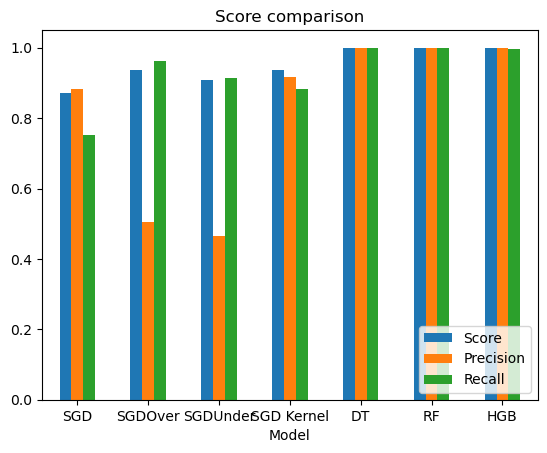

In [19]:
data_score_df = pd.DataFrame({'Model':['SGD', 'SGDOver', 'SGDUnder',
                    'SGD Kernel', 'DT', 'RF', 'HGB'],
               'Score': [0.871, 0.936, 0.907, 0.937, 1.000, 1.000, 0.999],
                            'Precision': [0.883, 0.506, 0.465, 0.917, 1.000, 1.000, 0.998],
                             'Recall' : [0.752, 0.961, 0.914, 0.882, 1.000, 1.000, 0.997]})
ax = data_score_df.plot.bar(x='Model', rot=0)
plt.title('Score comparison')
plt.legend(loc='lower right')

# Annexes
- Annexe 1 : distribution des features 'distance_from_last_transaction' et 'distance_from_last_transaction'
- Annexe 2 : exploiration des données par ACP (Analyse en Composante Principale)
- Annexe 3 : choix de la méthode scoring
- Annexe 4 : détail du modèle prédictif Linear SVC

## Annexe 1 : distribution des features 'distance_from_last_transaction' et 'distance_from_last_transaction'

In [ ]:
# recherche d'outliers sur la feature  ratio_to_median_purchase_price
x_index = ''distance_from_last_transaction''
x=df[x_index]

plt.hist(x, range=(x.min(), x.max()), bins = 200, color = 'green',
            edgecolor = 'green',log=True)
plt.xlabel('ratio_to_median_purchase_price')
plt.ylabel('nombres')
plt.title('distribution ratio_to_median_purchase_price')

In [ ]:
#feature 'distance_from_last_transaction'
boolean_mask = df['distance_from_last_transaction']> 4000
#df[boolean_mask]['distance_from_last_transaction'].value_counts()
df[boolean_mask]

In [ ]:
### recherche d'outliers sur la feature  ratio_to_median_purchase_price
x_index = ''distance_from_last_transaction''
x=dataset[x_index]

plt.hist(x, range=(x.min(), x.max()), bins = 200, color = 'green',
            edgecolor = 'green',log=True)
plt.xlabel('ratio_to_median_purchase_price')
plt.ylabel('nombres')
plt.title('distribution ratio_to_median_purchase_price')

In [ ]:
#feature 'ratio_to_median_purchase_price'
boolean_mask = df['ratio_to_median_purchase_price'] > 150
#df[boolean_mask]['ratio_to_median_purchase_price'].value_counts()
df[boolean_mask].head()

## Annexe  2 : exploiration des données par ACP (Analyse en Composante Principale)

### 1iere étape : ACP de référence sur des données non transformées
on constate une écrasement important de la composante principale qui explique à elle seule plus de 80% de la variance.
Ce constat milite en faveur d'une réduction des données

In [23]:
from sklearn.decomposition import PCA

In [24]:
#création de deux sous jeux de données pour vérifier l'homogénéité de la distribution 
X1,X2=train_test_split(df,test_size=0.5)

In [25]:
#déclaration des PCA sur les deux parties du jeu de données
pca_model_X1= PCA()
pca_model_X2=PCA()

In [26]:
pca_model_X1.fit(X1)
pca_model_X2.fit(X2)

PCA()

<IPython.core.display.Javascript object>


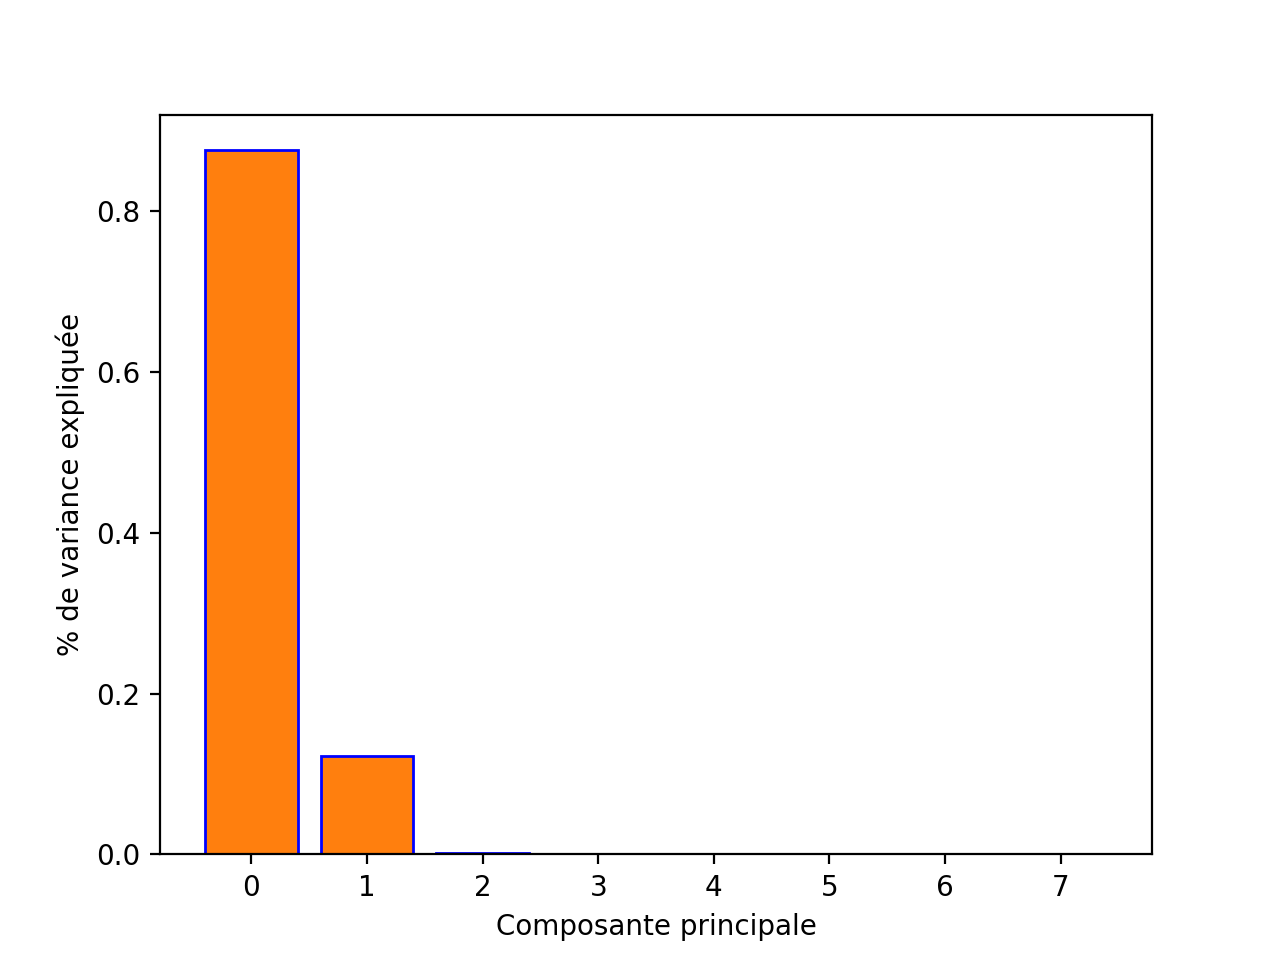

In [31]:
#calcul des valeurs propres et affichage => pas de différence entre les deux parties
ratios_X1=pca_model_X1.explained_variance_ratio_
ratios_X2=pca_model_X1.explained_variance_ratio_

plt.bar(range(len(ratios_X1)), ratios_X1)
plt.xticks(range(len(ratios_X1)))
plt.xlabel("Composante principale")
plt.ylabel("% de variance expliquée")
plt.show()


plt.bar(range(len(ratios_X2)), ratios_X2,edgecolor='blue')
plt.xticks(range(len(ratios_X2)))
plt.xlabel("Composante principale")
plt.ylabel("% de variance expliquée")
plt.show()

In [29]:
#affichage des vecteurs propres ->il y a un vecteur propre qui domine dans les deux parties (donc homogènes)
vecteurs_X1=pca_model_X1.components_
print("Composantes principales : ")
print(vecteurs_X1)

Composantes principales : 
[[ 9.99999352e-01  2.24403371e-04 -1.38222172e-04  7.32002416e-04
   1.14013461e-05 -1.45539828e-05 -1.02887696e-05  8.30598514e-04]
 [-2.25381570e-04  9.99999225e-01  1.40439583e-04 -1.63765452e-05
   5.48068217e-05 -1.46232192e-05  2.67620036e-07  1.21453513e-03]
 [ 9.90556665e-05 -1.97322786e-04  9.98895794e-01  5.30560379e-05
   4.24639893e-05 -6.33253514e-05  2.85910762e-04  4.69792828e-02]
 [ 1.15269616e-04  1.69767996e-04  7.57643968e-03  2.49161879e-03
   3.43206213e-01  1.07240513e-02 -9.26159314e-01 -1.55755458e-01]
 [-1.13487661e-05 -5.98814543e-05 -4.64144583e-04 -2.16189478e-03
   9.38046425e-01 -4.82558769e-04  3.46433216e-01  6.91418271e-03]
 [ 6.77319187e-04 -9.19592353e-05 -2.87138746e-03 -9.97322153e-01
   1.97060643e-03 -3.60720448e-02 -1.28551791e-02  6.22051442e-02]
 [ 2.23340916e-04  2.63739234e-04  9.76785224e-03 -4.87756101e-02
  -1.32535954e-02  9.76215816e-01  4.10781438e-02 -2.06555121e-01]
 [ 8.44372037e-04  1.16163101e-03  4.52314

Chaque ligne de pca.components_ représente le vecteur unitaire qui donne la direction d’un axe factoriel. Le vecteur pca.components_[i,:] correspond à la valeur propre pca.explained_variance_ratio_[i].

### 2 ieme étape : ACP avec des données centrées er réduites en supprimant les valeurs élevées

Cette partie est destinée à les potentiels outliers ne modifient pas fondamentalement les vecteurs propres.
Ici l'essai a été réalisé sur des données réduites et centrées.

In [40]:
boolean_mask = (df['distance_from_last_transaction']<4000) & (df['distance_from_home']<4000) & (df['ratio_to_median_purchase_price']<150)

# Applying the boolean filtering
X1= df[boolean_mask].reset_index(drop=True)

In [41]:
X3,X4,y3,y4=train_test_split(X1[all_features],X1[target_column],train_size=0.01)

In [42]:
#transformation de centrage et réduction aux variables 
X3_CR = preprocessing.scale(X3)

X3_pcaCR_model= PCA()
X3_pcaCR_model.fit(X3_CR)

X3_PCA_CR = X3_pcaCR_model.transform(X3_CR)
#print(X3_PCA_CR[:3,:])

In [43]:
X3_mNt = X3_pcaCR_model.transform(X3_CR)

<IPython.core.display.Javascript object>


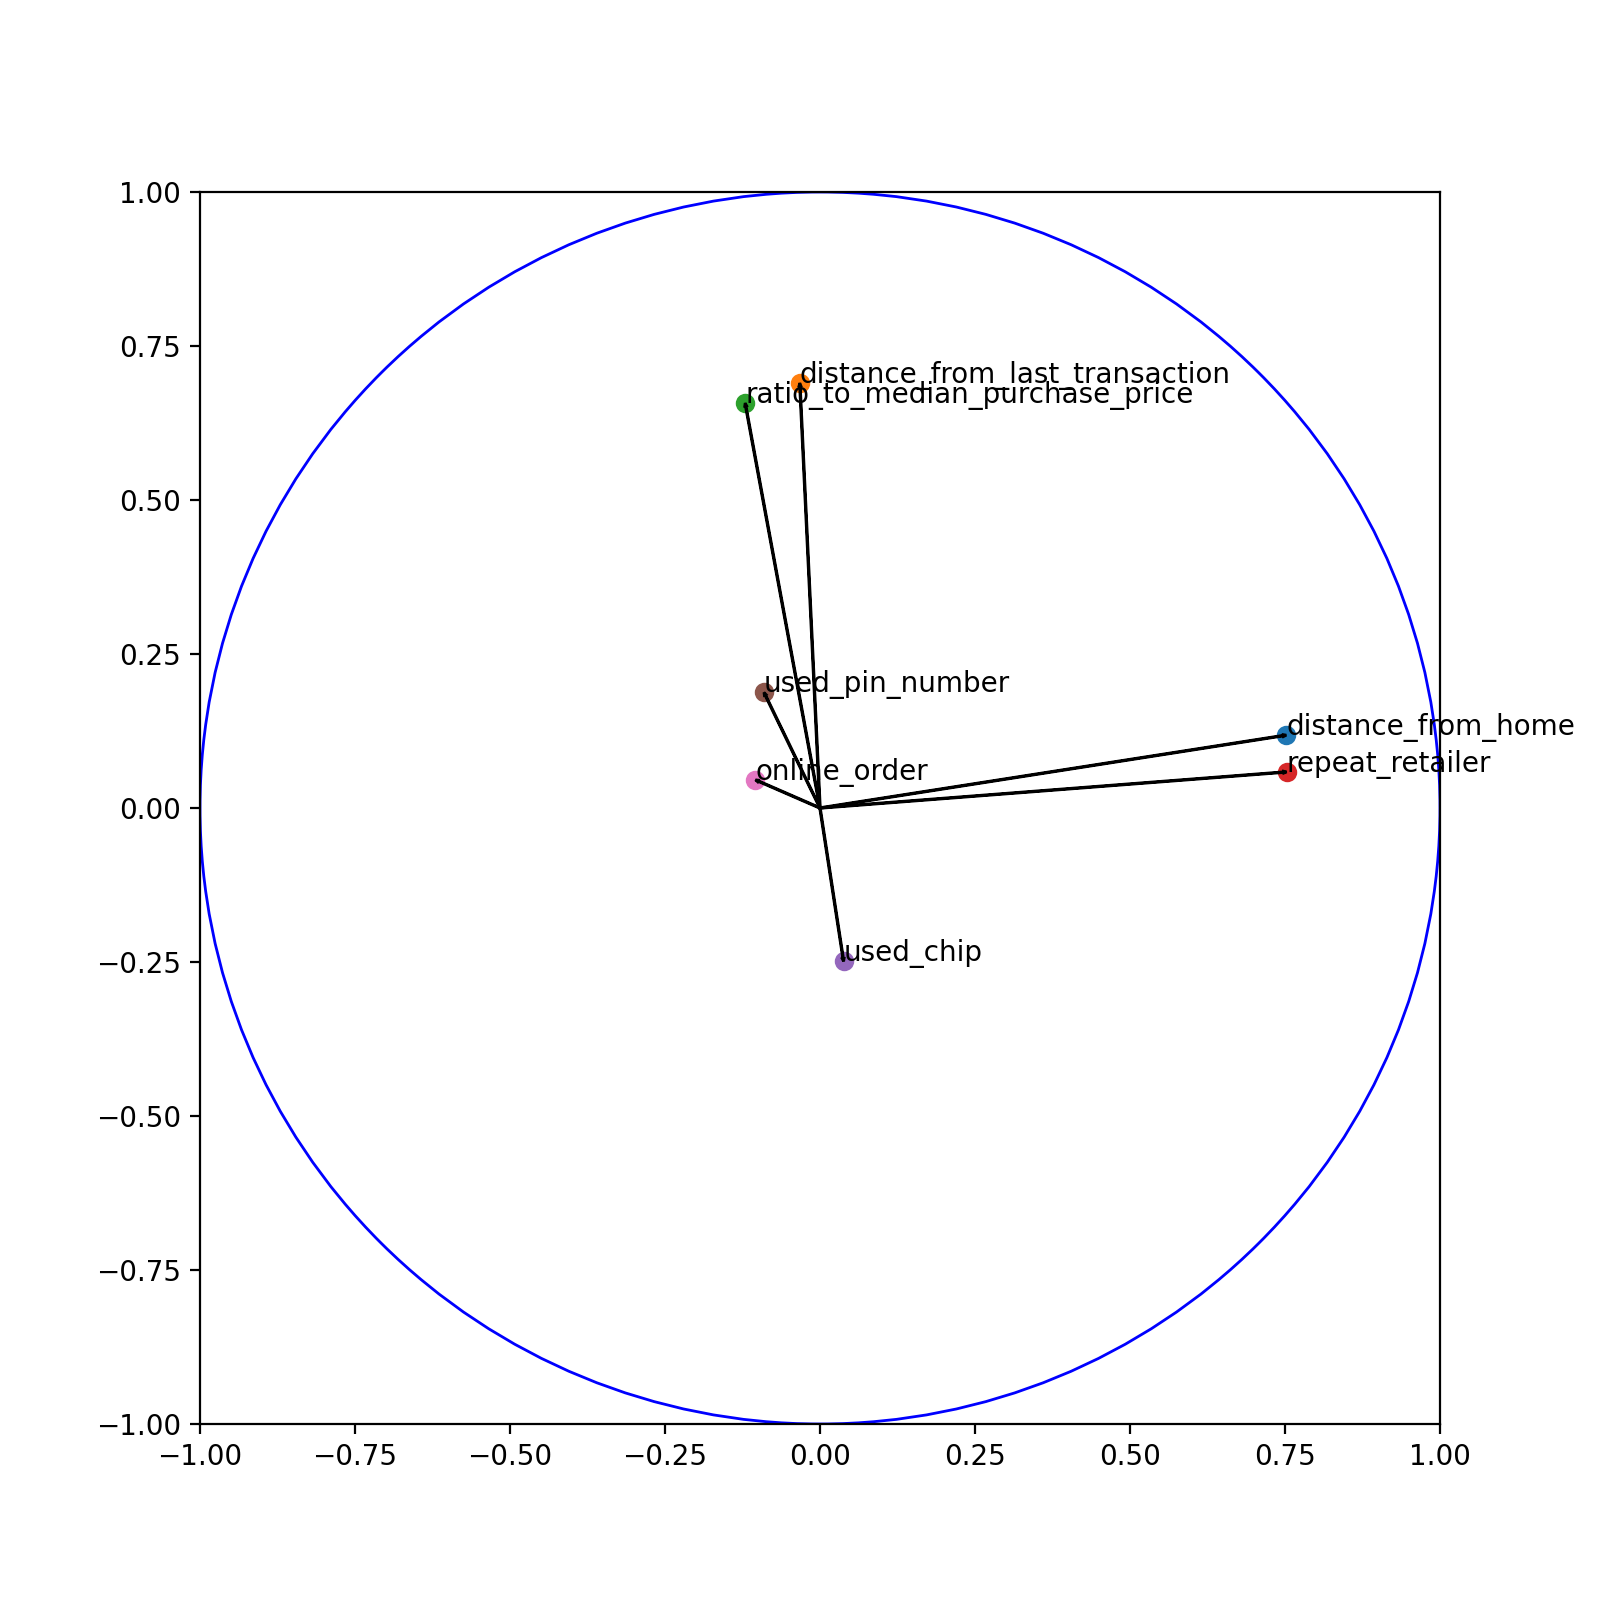

In [44]:
# On concerve grosso modo les mêmes regroupements & anti corrélation !: 
# distance from last transaction avec  ratio et pin number 
# distance from home & repeat retailer (non changé)
# et use chip en anti corrélation de ratio

X3_CR_T = X3_CR.transpose()
irlambdas = 1/np.sqrt(X3_pcaCR_model.explained_variance_)
mirlambdas = np.diagflat(irlambdas)

projections = (X3_CR_T.dot(X3_mNt)).dot(mirlambdas)/9999

nomsVars = np.array(all_features)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
cercle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(cercle)

for i in range(len(nomsVars)):
        x,y = projections[i,0], projections[i,1]
        ax.scatter(x,y)
        ax.arrow(0, 0, x, y, shape='full', lw=1, length_includes_head=True)
        ax.text(x, y, nomsVars[i])
plt.show()

### 3 ieme étape : ACP avec une transformation des données par standartScaler

Cette partie est destinée à monter  le scaler StandardScaler donne un résultat très proche de la transformation "scale" de centrage et réduction.

In [99]:
data_Allfeatures_StdScaled = preprocessor_StdScaler.fit_transform(df)

In [100]:
pca_model_AllStdScaled= PCA()
pca_model_AllStdScaled.fit(data_Allfeatures_StdScaled)

PCA()

[0.19457448 0.14179384 0.12534908 0.12509421 0.12486653 0.1247295
 0.10834291 0.05524945]


<IPython.core.display.Javascript object>


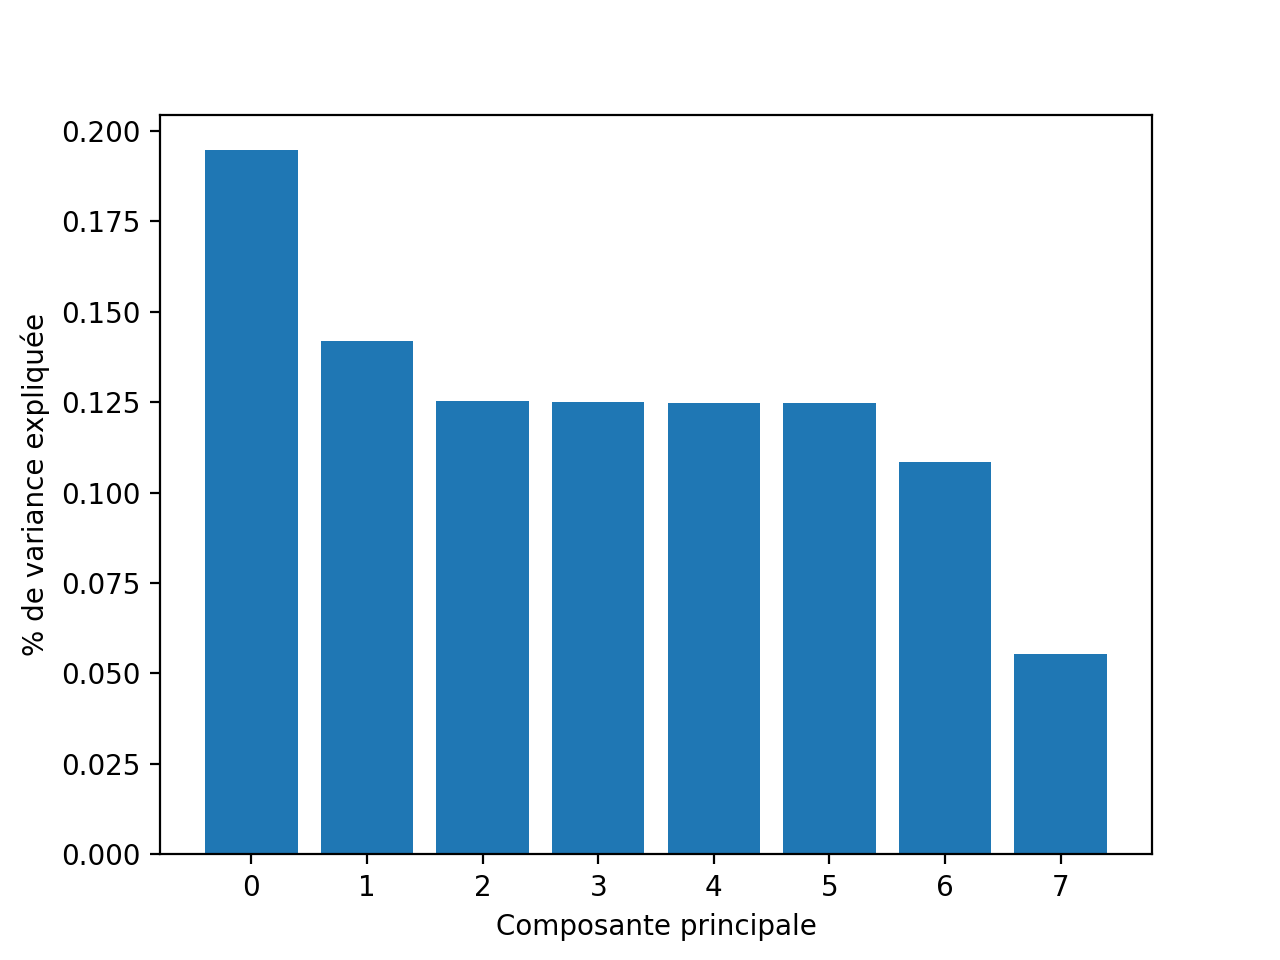

In [101]:
ratios_AllStdScaled = pca_model_AllStdScaled.explained_variance_ratio_
print(ratios_AllStdScaled)

plt.bar(range(len(ratios_AllStdScaled)), ratios_AllStdScaled)
plt.xticks(range(len(ratios_AllStdScaled)))
plt.xlabel("Composante principale")
plt.ylabel("% de variance expliquée")
plt.show()

### 4 ieme étape : ACP avec une transformation des données par robustScaler

Cette partie ainsi que la suite sont destinées à monter que ces scalers donnent moins d'importance à certaines features.

In [102]:
preprocessor_4 = ColumnTransformer([('Sdt_preprocessor', preprocessor_RobScaler,
      ['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price'])],
    remainder='passthrough', sparse_threshold=0)

data_feature_RScaled=preprocessor_4.fit_transform(df)

In [103]:
pcaR_model= PCA()
pcaR_model.fit(data_feature_RScaled)

ratios_RScaled = pcaR_model.explained_variance_ratio_
print(ratios_RScaled)

[8.49377861e-01 1.06494313e-01 3.57188741e-02 2.75697991e-03
 2.70823010e-03 1.21899571e-03 1.09863312e-03 6.26113667e-04]


<IPython.core.display.Javascript object>


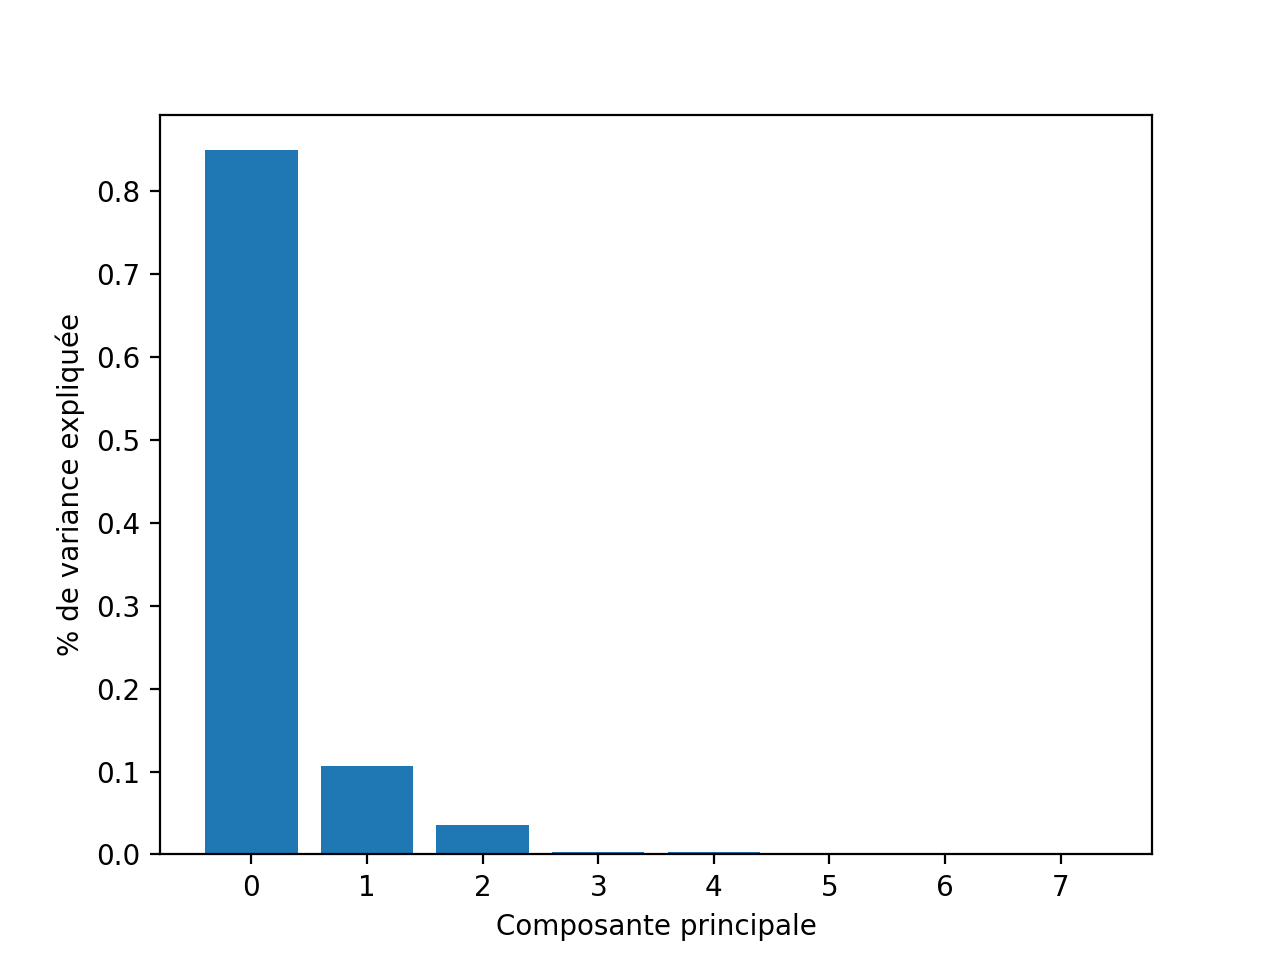

In [104]:
plt.bar(range(len(ratios_RScaled)), ratios_RScaled)
plt.xticks(range(len(ratios_RScaled)))
plt.xlabel("Composante principale")
plt.ylabel("% de variance expliquée")
plt.show()

### 5 ieme étape : ACP avec une transformation des données par MinMaxScaler

In [106]:
preprocessor_3 = ColumnTransformer([('Sdt_preprocessor', preprocessor_MMScaler,
      ['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price'])],
    remainder='passthrough', sparse_threshold=0)

data_feature_MMScaled=preprocessor_3.fit_transform(df)

In [107]:
pcaMM_model= PCA()
pcaMM_model.fit(data_feature_MMScaled)

ratios_MMScaled = pcaMM_model.explained_variance_ratio_
print(ratios_MMScaled)

[3.18222089e-01 3.11820796e-01 1.43098375e-01 1.28998675e-01
 9.76887949e-02 1.16976933e-04 4.78558526e-05 6.43638258e-06]


<IPython.core.display.Javascript object>


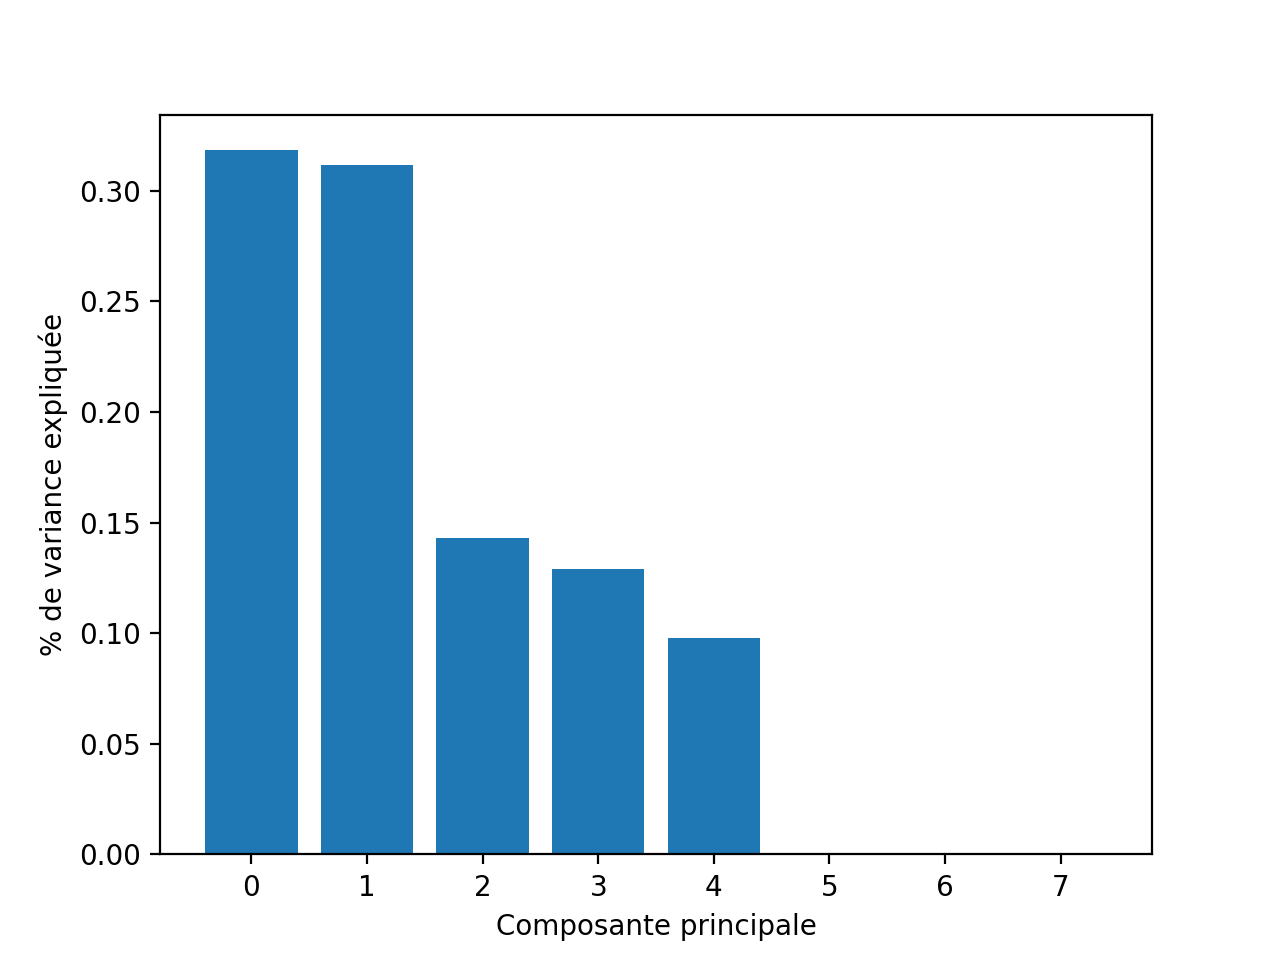

In [108]:
plt.bar(range(len(ratios_MMScaled)), ratios_MMScaled)
plt.xticks(range(len(ratios_MMScaled)))
plt.xlabel("Composante principale")
plt.ylabel("% de variance expliquée")
plt.show()

## Annexe 3 : choix de la méthode de choix du scoring

Essais comparés des scores obtenus avec le 'balanced_accuracy' et 'accuracy' avec plusieurs types de classifiers.
La comparaison avec le classifer Dummy permet de constater l'erreur apportée par le score accuracy par rapport au balenced_accary. Cette erreur est également constaté pour le classifier SVC.

A noter que dans le cas d'une transformation préalable des features, cet écart se réduit même si le score accuracy reste le plus optimiste des deux. 

### Classifiers Dummy avec la stratégie "most frequent" (the “chance level” for imbalanced classification problems) 

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_base= DummyClassifier(strategy="most_frequent")

In [16]:
score_dummy_base_accuray = cross_val_score(
    dummy_base, X, y, cv=cv, scoring="accuracy",error_score='raise')

score_dummy_base_balanced_accuray = cross_val_score(
    dummy_base, X, y, cv=cv, scoring="balanced_accuracy",error_score='raise')

In [18]:
print(f"Accuracy score: {score_dummy_base_accuray.mean():.3f} ± {score_dummy_base_accuray.std():.3f}")
print(f"Balanced Accuracy score: {score_dummy_base_balanced_accuray.mean():.3f} ± {score_dummy_base_balanced_accuray.std():.3f}")

Accuracy score: 0.913 ± 0.000
Balanced Accuracy score: 0.500 ± 0.000


### Classifiers SVC sans transformation des données

In [21]:
from sklearn.svm import SVC

model_svc=SVC()

In [23]:
# attention SVC coût quadratique en fonction du nombre de données / on limite à 20K
score_svc_base_accuracy=cross_val_score(
    model_svc, X[:20000], y[:20000], cv=cv, scoring="accuracy",error_score='raise')

score_svc_balanced_accuracy=cross_val_score(
    model_svc, X[:20000], y[:20000], cv=cv, scoring="balanced_accuracy",error_score='raise')

In [24]:
print(f"Accuracy score: {score_svc_base_accuracy.mean():.3f} ± {score_svc_base_accuracy.std():.3f}")
print(f"Balanced Accuracy score: {score_svc_balanced_accuracy.mean():.3f} ± {score_svc_balanced_accuracy.std():.3f}")

Accuracy score: 0.918 ± 0.001
Balanced Accuracy score: 0.557 ± 0.007


### Classifiers SVC avec  transformation des données

In [40]:
#transformation de ttes les données 
X_StdScaled=preprocessor_StdScaler.fit_transform(X)

In [41]:
# attention SVC coût quadratique en fonction du nombre de données / on limite à 20K
score_svc_base_accuracy_XScaled=cross_val_score(
    model_svc, X_StdScaled[:20000], y[:20000], cv=cv, scoring="accuracy",error_score='raise')

score_svc_balanced_accuracy_XScaled=cross_val_score(
    model_svc, X_StdScaled[:20000], y[:20000], cv=cv, scoring="balanced_accuracy",error_score='raise')

In [42]:
print(f"Accuracy score: {score_svc_base_accuracy_XScaled.mean():.3f} ± {score_svc_base_accuracy_XScaled.std():.3f}")
print(f"Balanced Accuracy score: {score_svc_balanced_accuracy_XScaled.mean():.3f} ± {score_svc_balanced_accuracy_XScaled.std():.3f}")

Accuracy score: 0.992 ± 0.001
Balanced Accuracy score: 0.958 ± 0.009


In [56]:
# synthèse

DFscore_dummy_base_accuray = pd.Series(score_dummy_base_accuray, name="Dummy_Accuracy")
DFscore_dummy_base_BalancedAccuray = pd.Series(score_dummy_base_balanced_accuray, name="Dummy_BalancedAccuracy")

DFscore_SVC_base_accuray = pd.Series(score_svc_base_accuracy, name="SVC_Accuracy")
DFscore_SVC_base_BalancedAccuray = pd.Series(score_svc_balanced_accuracy, name="SVC_BalancedAccuracy")

DFscore_SVC_Scaled_accuray = pd.Series(score_svc_base_accuracy_XScaled, name="SVC_Scaled_Accuracy")
DFscore_SVC_Scaled_BalancedAccuray = pd.Series(score_svc_balanced_accuracy_XScaled, name="SVC_Scaled_BalancedAccuracy")

In [57]:

all_scores= pd.concat(
    [DFscore_dummy_base_accuray,DFscore_dummy_base_BalancedAccuray,
     DFscore_SVC_base_accuray,DFscore_SVC_base_BalancedAccuray,
     DFscore_SVC_Scaled_accuray,DFscore_SVC_Scaled_BalancedAccuray],
    axis=1,
)
all_scores.head()

,Dummy_Accuracy,Dummy_BalancedAccuracy,SVC_Accuracy,SVC_BalancedAccuracy,SVC_Scaled_Accuracy,SVC_Scaled_BalancedAccuracy
0,0.912600,0.5,0.91925,0.547649,0.99125,0.952943
1,0.912600,0.5,0.91575,0.562907,0.99250,0.958910
2,0.912595,0.5,0.91900,0.566006,0.99325,0.967246
3,0.912595,0.5,0.91875,0.557943,0.98975,0.944196
4,0.912595,0.5,0.91650,0.548787,0.99350,0.966062


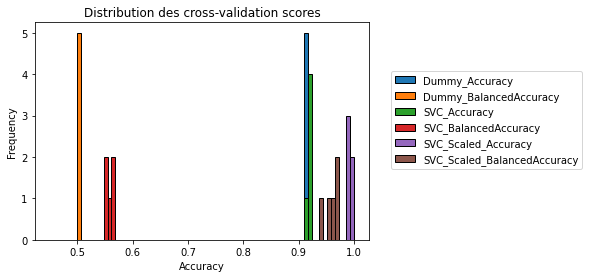

In [58]:
bins = np.linspace(start=0.45, stop=1, num=80)
all_scores.plot.hist(bins=bins, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Accuracy")
_ = plt.title("Distribution des cross-validation scores")

## Annexe 4 : détail du modèle prédictif Linear SVC avec transformation de données

In [ ]:
#split pour évaluer la performance du modèle 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

In [ ]:
#Déclaration du pipeline de base avec les hyperparamètres par défaut pour le classifier
#Prefer dual=False when n_samples > n_features.
LSVClassifier_model = Pipeline([
            ("preprocessor", all_preprocessors),("classifier", LinearSVC(dual=False))])

In [ ]:
#pour récupérer les libellés exacts à déclarer dans le randomsearch
#bien noter le double underscore "_"
#LSVClassifier_model.get_params()

In [ ]:
%%time

#attention ne pas hesiter n_iter = 500 (attention impact temps machine)
#attention scoring "balanced_accuracy" car distribution modalités fraud déséquilibrée
#attention StratifiedKFold pour les splits pour ""preserving the original class frequencies"

param_distributions = {
#    'classifier__loss' :('hinge','squared_hinge'), #attention des combinaisons interdites
    'classifier__penalty': ('l2','l1'),
    'preprocessor': all_preprocessors,
    'classifier__C':loguniform(0.001, 10)
} 

LSVClassifier_model_random_search = RandomizedSearchCV(
    LSVClassifier_model, param_distributions=param_distributions, n_iter=800, #tenir compte message erreur lors du fit
    cv=cv, verbose=1,scoring='balanced_accuracy',error_score='raise',n_jobs=2,
)

In [ ]:
%%time

# fit du random search sur SGDClassifier quelques minutes avec 20K données
LSVClassifier_model_random_search.fit(X_train[:20000],y_train[:20000])

In [ ]:
#affichage des meilleurs hyperparamètres trouvés
print(f"The best set of parameters is: "
      f"{LSVClassifier_model_random_search.best_params_}")

In [ ]:
#code tiré du cours du MOOC Inria ML
#stockage des données dans DataFrame en vue d'une visualisation des scores
cv_results1 = pd.DataFrame(LSVClassifier_model_random_search.cv_results_,dtype=float).sort_values(
    "mean_test_score", ascending=False)
#cv_results[["param_classifier__learning_rate","param_classifier__max_leaf_nodes","mean_test_score","std_test_score"]]

In [ ]:
#pour repérer le nommage des hyperparamètres dans le cv_results
cv_results1.head(5)

In [ ]:
#vérification affichage pour plus de facilité de lecture
cv_results1[['rank_test_score','std_test_score','mean_test_score','param_preprocessor',
            'param_classifier__C','param_classifier__penalty']].head(5)


In [ ]:
#commande intéressante / permet de transformer la liste de résultat en tableau à deux entrées
#code tiré du cours du MOOC Inria ML & adapté
#ici choix du terme de régularisation penalty et de la constante alpha de multiplication de cette régularisation
pivoted_cv_results1= cv_results1.head(10).pivot_table(
    values="mean_test_score", index=["param_classifier__C"],
    columns=["param_classifier__penalty"],aggfunc=np.max)

pivoted_cv_results

In [ ]:
ax = sns.heatmap(pivoted_cv_results1, annot=True, cmap="YlGnBu", vmin=0.5,
                 vmax=0.99,fmt='.3g')
ax.invert_yaxis()